# Lead Scoring Case Study

- Understand the valrous columns
- Missing value imputation
    - Replace Select with NaN
- check data imbalance
- Outlier treatment
- Dummy variable creation 
- Test train split
- Standardisation
- Build model
- Feature elimination
- Model evaluation

- Attach a lead score for each row
- Find a cut off for hot-lead

- Remove utils

## Functions

In [6905]:
import importlib

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

import utils

In [6906]:
'''def getXy(df, cols=None):
    if cols is None:
        cols = list(set(df.columns)-set(['cnt']))

    X = df[cols]
    y = df[['cnt']]
    print(f"Ip - Columns: {len(cols)}, {cols}")
    print(f"X - Columns: {len(X.columns)}, {X.columns.tolist()}")
    print(f"y - Columns: {len(y.columns)}, {y.columns.tolist()}")
    return X, y
'''

def runRFE(numFeatures, X, y):
    lm = LogisticRegression()
    rfe = RFE(lm, numFeatures)
    rfe = rfe.fit(X,y)
    list(zip(X.columns, rfe.support_, rfe.ranking_))
    cols = X.columns[rfe.support_].tolist()
    print("Columns selected by RFE:", cols)

    dropped_cols.extend(list(set(X.columns)-set(X.columns[rfe.support_].tolist())))
    print("Columns dropped by RFE:", dropped_cols)

    return cols

# Build a  Linear Regression Model
def buildLogRegModel(X, y):
    X_sm = sm.add_constant(X)

    # create the model
    lr = sm.GLM(y, X_sm, family = sm.families.Binomial())
    lr_model = lr.fit()
    #print(lr_model.params)
    print(lr_model.summary())
    return lr_model, X_sm

# Calculate & print VIF
def getVIF(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    print(vif)

dropped_cols = []
# Drop one column from the current dataset and build the model. Store the dropped column in dropped_cols so that these can be dropped from the test dataset also
def dropColumnAndBuildModel(X, y, col=""):
    global dropped_cols
    #print(X_train.columns)
    if col != "":  
        X.drop(columns=col, inplace=True)
        dropped_cols.append(col)
    lr_model, X_sm = buildLogRegModel(X, y)
    getVIF(X)
    return lr_model, X_sm

In [6907]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
def confusionmatrix(y_train, col_actual, col_predicted):
    confusion = metrics.confusion_matrix(y_train[col_actual], y_train[col_predicted])
    print(confusion)

    # Let's look at other metrices, Sensitivity Specificity
    TP, TN,FP, FN  = confusion[1,1], confusion[0,0], confusion[0,1], confusion[1,0] # false negativies
    sensitivity = TP/float (TP+FN)
    specificity = TN/float (TN+FP)
    fpr = FP/float(TN+FP)
    ppv = TP/float(TP+FP)

    print(f"Accuracy: {round(100 * metrics.accuracy_score(y_train[col_actual],y_train[col_predicted]),2)}% "
          f"Sensitivity: {round(sensitivity*100,2)}% Specificity: {round(specificity*100,2)}% FPR: {round(fpr*100,2)}% PPV: {round(ppv*100,2)}%")

def draw_roc (actual,probs):
    fpr,tpr,thresholds = metrics.roc_curve (actual,probs,drop_intermediate = False)
    auc_score = metrics.roc_auc_score (actual,probs)
    plt.figure (figsize =(5,5))
    plt.figure()
    plt.plot(fpr, tpr, label = 'ROC Curve(area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic - Lead Score')
    plt.legend(loc="lower right")
    plt.show()
    
    return None

def predict(model, X, y):
    y_pred = model.predict(X)
    #print(y_pred [:5])
    #print((y_pred*100).astype(int)[:5])

    y_pred = y_pred.values.reshape(-1)
    #print(y_pred[:5])

    y_pred_final = pd.DataFrame ({'Lead_Actual': y.values, 'Lead_Prob' : y_pred})
    y_pred_final['Lead_ID'] = y.index
    #print(y_pred_final.head())

    y_pred_final['Lead_Predicted'] = y_pred_final['Lead_Prob'].map(lambda x: 1 if x>0.5 else 0)

    ## LOOK at the head of the data
    print(y_pred_final.head())
    return y_pred_final

## Read data set

In [6908]:
df = pd.read_csv("Leads.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

### Rename, Group, Reorder columns

In [6909]:
# Rename the columns that have long names or have spaces
df.rename(columns={'Prospect ID':'ProspectID'}, inplace=True)
df.rename(columns={'What is your current occupation':'Occupation', 'What matters most to you in choosing a course':'Reason'}, inplace=True)
df.rename(columns={'How did you hear about X Education':'Found', 'Search':'AdSearch', 'Magazine':'AdMagazine', 'Newspaper Article':'AdNewspaperArticle',\
                    'Newspaper':'AdNewspaper', 'X Education Forums':'AdForums','Digital Advertisement':'AdDigital', 'Through Recommendations':'Recommendations' }, inplace=True)
df.rename(columns={'Do Not Email':"NoEmail", 'Do Not Call':"NoCall",'Receive More Updates About Our Courses':"CourseUpdates", \
                    'Update me on Supply Chain Content':"SCCUpdates", 'Get updates on DM Content':"DMCUpdates",'A free copy of Mastering The Interview':"FreeCopy",\
                    'I agree to pay the amount through cheque':"PayAmount"}, inplace=True)
df.rename(columns={'Page Views Per Visit':'PageViews', 'Total Time Spent on Website':'TimeSpent','Last Activity':'LastActivity','Last Notable Activity':'LastNotableActivity'}, inplace=True)
df.rename(columns={'Lead Number':'LeadNumber', 'Lead Origin':'LeadOrigin', 'Lead Source': 'LeadSource','Lead Quality':'LeadQuality', 'Lead Profile':'LeadProfile'}, inplace=True)
df.rename(columns={'Asymmetrique Activity Index':'ActivityIndex', 'Asymmetrique Profile Index':'ProfileIndex', 'Asymmetrique Activity Score':'ActivityScore', \
                    'Asymmetrique Profile Score':'ProfileScore'}, inplace=True)
#df.rename(columns={}, inplace=True)

# Group the columns that are similar so that these columns can be analysed together
COLS_ID         = ['ProspectID'] # customer id
COLS_LOC        = ['Country','City']

COLS_PROF       = ['Occupation','Specialization' , 'Reason']
COLS_AD         = ['Found', 'AdSearch', 'AdMagazine', 'AdNewspaperArticle', 'AdForums', 'AdNewspaper', 'AdDigital', 'Recommendations']
COLS_PREF       = ['NoEmail', 'NoCall','CourseUpdates', 'SCCUpdates', 'DMCUpdates','FreeCopy','PayAmount']

COLS_ACTIVTIY   = ['TotalVisits', 'PageViews', 'TimeSpent','LastActivity', 'LastNotableActivity']

COLS_LEAD       = ['LeadNumber', 'LeadOrigin', 'LeadSource','LeadQuality',  'LeadProfile', 'Tags']
COLS_INDEXSCORE = ['ActivityIndex', 'ProfileIndex', 'ActivityScore', 'ProfileScore']

COLS_TARGET     = ['Converted']

# Re-order/sequence the columns based on the workflow
df = df[COLS_ID + COLS_LOC + COLS_PROF + COLS_AD + COLS_PREF + COLS_ACTIVTIY + COLS_LEAD + COLS_INDEXSCORE + COLS_TARGET]

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ProspectID           9240 non-null   object 
 1   Country              6779 non-null   object 
 2   City                 7820 non-null   object 
 3   Occupation           6550 non-null   object 
 4   Specialization       7802 non-null   object 
 5   Reason               6531 non-null   object 
 6   Found                7033 non-null   object 
 7   AdSearch             9240 non-null   object 
 8   AdMagazine           9240 non-null   object 
 9   AdNewspaperArticle   9240 non-null   object 
 10  AdForums             9240 non-null   object 
 11  AdNewspaper          9240 non-null   object 
 12  AdDigital            9240 non-null   object 
 13  Recommendations      9240 non-null   object 
 14  NoEmail              9240 non-null   object 
 15  NoCall               9240 non-null   o

,ProspectID,Country,City,Occupation,Specialization,Reason,Found,AdSearch,AdMagazine,AdNewspaperArticle,...,LeadOrigin,LeadSource,LeadQuality,LeadProfile,Tags,ActivityIndex,ProfileIndex,ActivityScore,ProfileScore,Converted
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,NaN,Select,Unemployed,Select,Better Career Prospects,Select,No,No,No,...,API,Olark Chat,Low in Relevance,Select,Interested in other courses,02.Medium,02.Medium,15.0,15.0,0
1,2a272436-5132-4136-86fa-dcc88c88f482,India,Select,Unemployed,Select,Better Career Prospects,Select,No,No,No,...,API,Organic Search,NaN,Select,Ringing,02.Medium,02.Medium,15.0,15.0,0
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,India,Mumbai,Student,Business Administration,Better Career Prospects,Select,No,No,No,...,Landing Page Submission,Direct Traffic,Might be,Potential Lead,Will revert after reading the email,02.Medium,01.High,14.0,20.0,1
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,India,Mumbai,Unemployed,Media and Advertising,Better Career Prospects,Word Of Mouth,No,No,No,...,Landing Page Submission,Direct Traffic,Not Sure,Select,Ringing,02.Medium,01.High,13.0,17.0,0
4,3256f628-e534-4826-9d63-4a8b88782852,India,Mumbai,Unemployed,Select,Better Career Prospects,Other,No,No,No,...,Landing Page Submission,Google,Might be,Select,Will revert after reading the email,02.Medium,01.High,15.0,18.0,1


In [6910]:
COLS = df.columns.tolist(); utils.colDetails(COLS, "COLS")

COLS_CAT = df.select_dtypes(include=['object']).columns; 
COLS_CAT = list(set(COLS_CAT) - set(['Prospect ID']))
utils.colDetails(COLS_CAT, "COLS_CAT")

COLS_NULL = df[df.columns[df.isnull().any()]].columns.tolist(); utils.colDetails(COLS_NULL, "COLS_NULL")


COLS: 37 ['ProspectID', 'Country', 'City', 'Occupation', 'Specialization', 'Reason', 'Found', 'AdSearch', 'AdMagazine', 'AdNewspaperArticle', 'AdForums', 'AdNewspaper', 'AdDigital', 'Recommendations', 'NoEmail', 'NoCall', 'CourseUpdates', 'SCCUpdates', 'DMCUpdates', 'FreeCopy', 'PayAmount', 'TotalVisits', 'PageViews', 'TimeSpent', 'LastActivity', 'LastNotableActivity', 'LeadNumber', 'LeadOrigin', 'LeadSource', 'LeadQuality', 'LeadProfile', 'Tags', 'ActivityIndex', 'ProfileIndex', 'ActivityScore', 'ProfileScore', 'Converted']

COLS_CAT: 30 ['Tags', 'Country', 'AdNewspaper', 'AdNewspaperArticle', 'Specialization', 'LeadOrigin', 'Occupation', 'ProspectID', 'LeadSource', 'AdForums', 'AdDigital', 'CourseUpdates', 'ActivityIndex', 'NoEmail', 'LeadQuality', 'FreeCopy', 'DMCUpdates', 'ProfileIndex', 'LastActivity', 'AdSearch', 'Recommendations', 'LeadProfile', 'LastNotableActivity', 'City', 'SCCUpdates', 'Reason', 'AdMagazine', 'PayAmount', 'NoCall', 'Found']

COLS_NULL: 17 ['Country', 'City'

## Exploratory Data Analysis

### Missing Values + Outliers

In [6911]:
df[df.columns[df.isnull().any()]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         6779 non-null   object 
 1   City            7820 non-null   object 
 2   Occupation      6550 non-null   object 
 3   Specialization  7802 non-null   object 
 4   Reason          6531 non-null   object 
 5   Found           7033 non-null   object 
 6   TotalVisits     9103 non-null   float64
 7   PageViews       9103 non-null   float64
 8   LastActivity    9137 non-null   object 
 9   LeadSource      9204 non-null   object 
 10  LeadQuality     4473 non-null   object 
 11  LeadProfile     6531 non-null   object 
 12  Tags            5887 non-null   object 
 13  ActivityIndex   5022 non-null   object 
 14  ProfileIndex    5022 non-null   object 
 15  ActivityScore   5022 non-null   float64
 16  ProfileScore    5022 non-null   float64
dtypes: float64(4), object(13)
memory 

<AxesSubplot:>

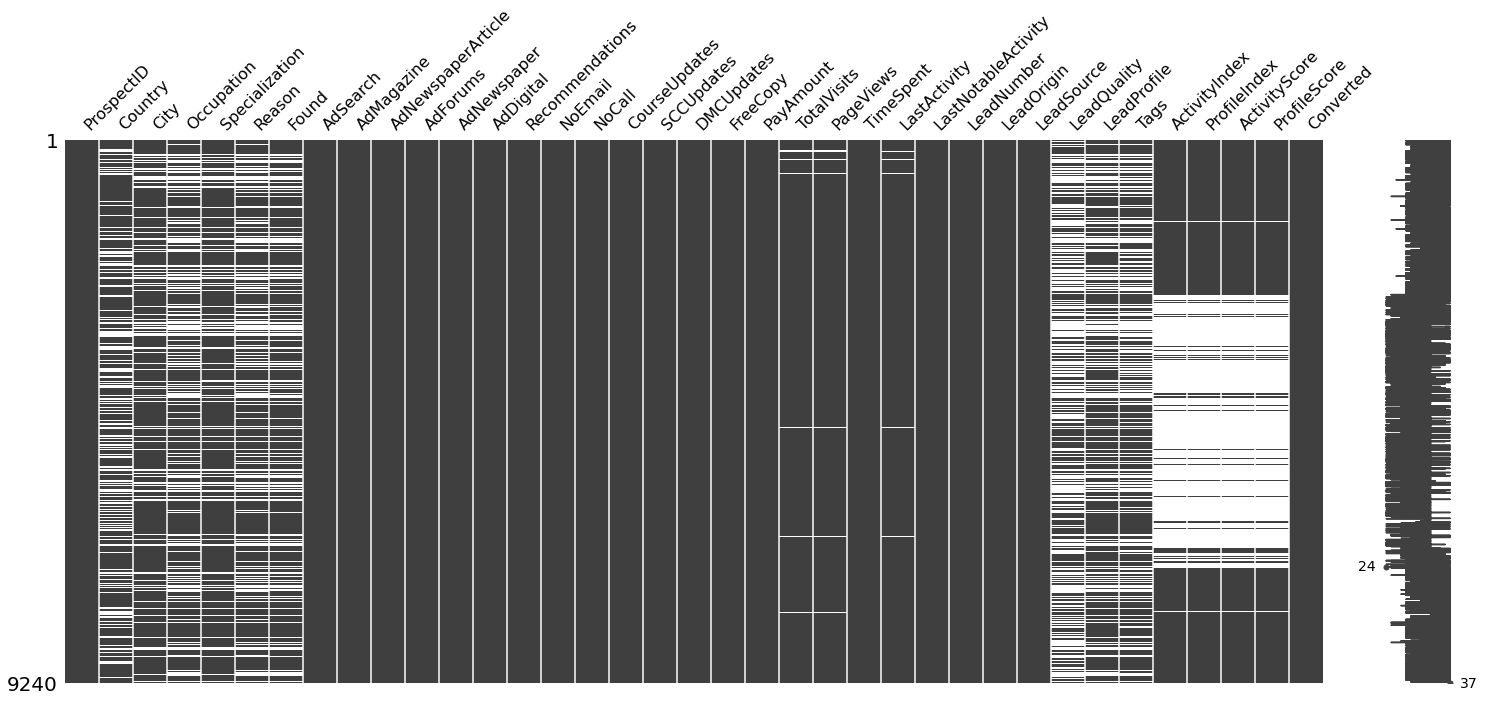

In [6912]:
import missingno as msno
msno.matrix(df)

- Columns have lot of missing values
    - Country, City, Occupation, Reason, Specialization, Found, LeadQuality, LeadProfile, Tags
    - Activity/Profile Index/Score 
- Columns with less number of missing values
    - TotalVisits and PageViews have missing values for the same rows
    - LastActivity

<AxesSubplot:>

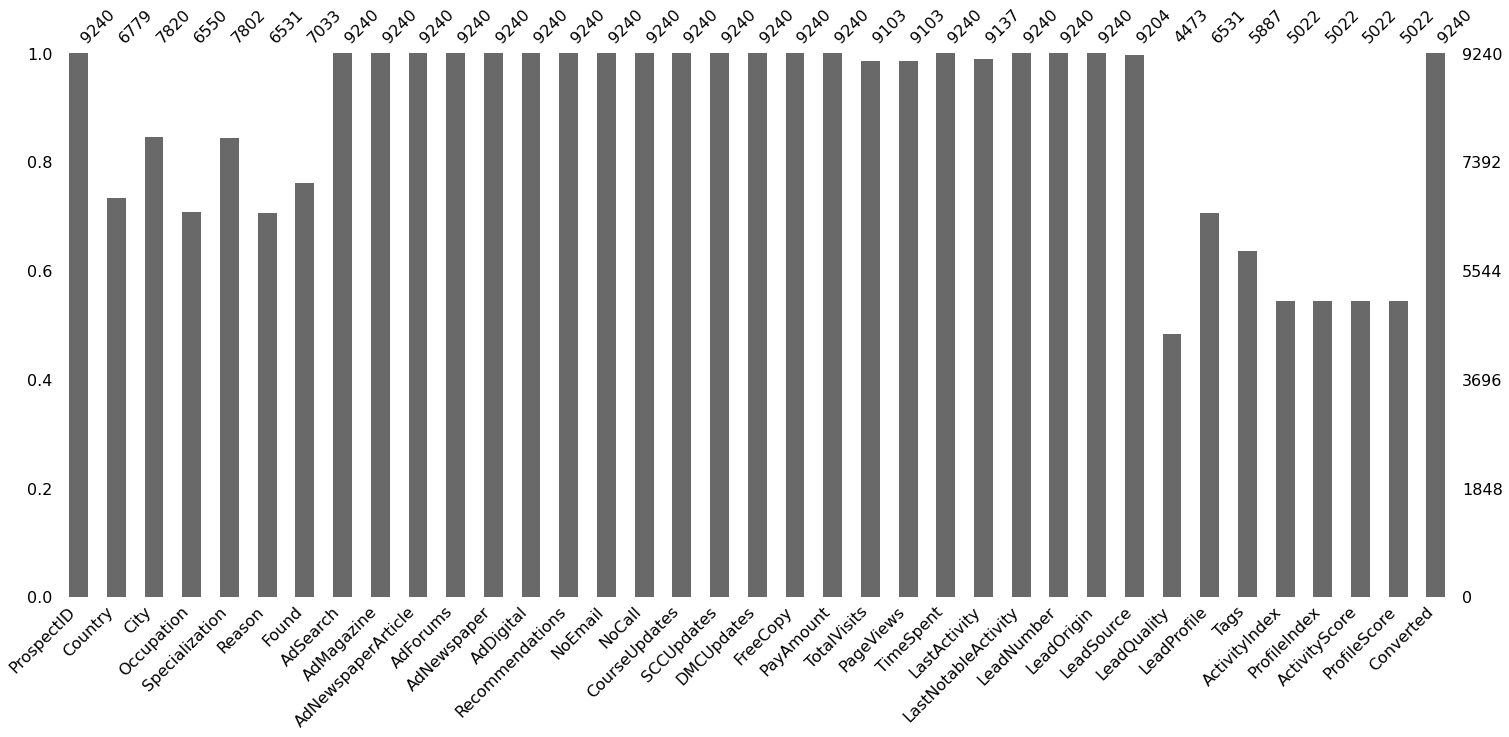

In [6913]:
msno.bar(df)

In [6914]:
TOTAL = df.shape[0]
for col in COLUMNS:
    nan = df[col].isnull().sum()
    select = df[df[col]=='Select'].shape[0]
    if nan > 0 or select > 0:
        print(f"{col:50}: {df[col].dtype.name:8} : {nan:6d} : {100 * nan/TOTAL:6.2f}% : {select:4d} : {100 * select/TOTAL:6.2f}%", end='')
        print()

Country                                           : object   :   2461 :  26.63% :    0 :   0.00%
City                                              : object   :   1420 :  15.37% : 2249 :  24.34%
Occupation                                        : object   :   2690 :  29.11% :    0 :   0.00%
Reason                                            : object   :   2709 :  29.32% :    0 :   0.00%
Specialization                                    : object   :   1438 :  15.56% : 1942 :  21.02%
Found                                             : object   :   2207 :  23.89% : 5043 :  54.58%
TotalVisits                                       : float64  :    137 :   1.48% :    0 :   0.00%
PageViews                                         : float64  :    137 :   1.48% :    0 :   0.00%
LastActivity                                      : object   :    103 :   1.11% :    0 :   0.00%
LeadSource                                        : object   :     36 :   0.39% :    0 :   0.00%
LeadQuality                   

In [6915]:
for col in COLUMNS:
    nan = df[col].isnull().sum()
    select = df[df[col]=='Select'].shape[0]
    if nan > 0 or select > 0:
        print(f"{col:50}: {df[col].dtype.name:8} : {nan:6d} : {100 * nan/TOTAL:6.2f}% : {select:4d} : {100 * select/TOTAL:6.2f}%", end='')
        print()

Country                                           : object   :   2461 :  26.63% :    0 :   0.00%
City                                              : object   :   1420 :  15.37% : 2249 :  24.34%
Occupation                                        : object   :   2690 :  29.11% :    0 :   0.00%
Reason                                            : object   :   2709 :  29.32% :    0 :   0.00%
Specialization                                    : object   :   1438 :  15.56% : 1942 :  21.02%
Found                                             : object   :   2207 :  23.89% : 5043 :  54.58%
TotalVisits                                       : float64  :    137 :   1.48% :    0 :   0.00%
PageViews                                         : float64  :    137 :   1.48% :    0 :   0.00%
LastActivity                                      : object   :    103 :   1.11% :    0 :   0.00%
LeadSource                                        : object   :     36 :   0.39% :    0 :   0.00%
LeadQuality                   

### COLUMNS - IDs
Identifiers of customer and lead
- Drop them for the model building

In [6916]:
df[COLS_ID][:5]

,ProspectID
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620
1,2a272436-5132-4136-86fa-dcc88c88f482
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc
4,3256f628-e534-4826-9d63-4a8b88782852


In [6917]:
for col in COLS_ID:
    utils.colInfo1(df, col, showValues=False)

ProspectID: object  :    0, 0.0% : 


In [6918]:
# Store the prospect ids in a separate dataframe for later
df_prospectid = df[COLS_ID]
df_prospectid[:5]

,ProspectID
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620
1,2a272436-5132-4136-86fa-dcc88c88f482
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc
4,3256f628-e534-4826-9d63-4a8b88782852


In [6919]:
df.drop(columns=COLS_ID, inplace=True)
df.shape

(9240, 36)

- The prospect Ids are all unique and no missing values.
- This need not be part of the model

### COLUMNS - LOC

In [6920]:
df[COLS_LOC][:5]

,Country,City
0,NaN,Select
1,India,Select
2,India,Mumbai
3,India,Mumbai
4,India,Mumbai


In [6921]:
for col in COLS_LOC:
    utils.colInfo1(df, col)

Country   : object  : 2461, 26.6% :   39, 0.4% : ['nan', 'Asia/Pacific Region', 'Australia', 'Bahrain', 'Bangladesh', 'Belgium', 'Canada', 'China', 'Denmark', 'France', 'Germany', 'Ghana', 'Hong Kong', 'India', 'Indonesia', 'Italy', 'Kenya', 'Kuwait', 'Liberia', 'Malaysia', 'Netherlands', 'Nigeria', 'Oman', 'Philippines', 'Qatar', 'Russia', 'Saudi Arabia', 'Singapore', 'South Africa', 'Sri Lanka', 'Sweden', 'Switzerland', 'Tanzania', 'Uganda', 'United Arab Emirates', 'United Kingdom', 'United States', 'Vietnam', 'unknown']
City      : object  : 1420, 15.4% :    8, 0.1% : ['nan', 'Mumbai', 'Other Cities', 'Other Cities of Maharashtra', 'Other Metro Cities', 'Select', 'Thane & Outskirts', 'Tier II Cities']


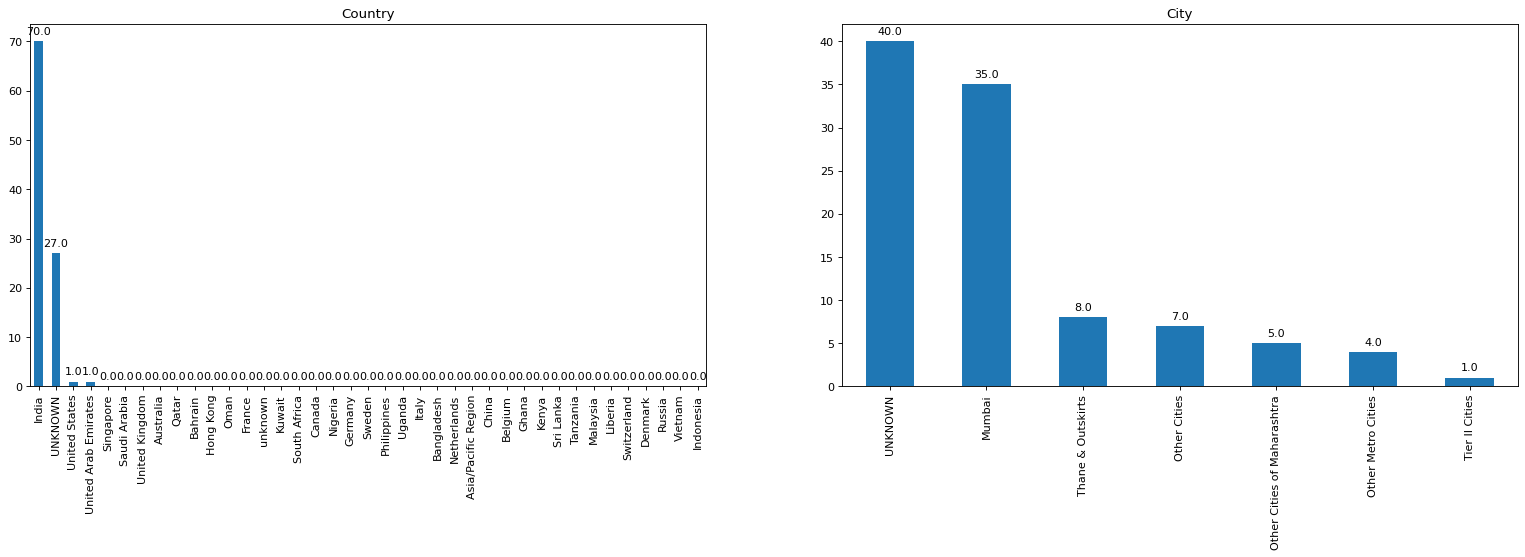

In [6922]:
plt.figure(figsize=(24, 6), dpi=80)
ax = plt.subplot(1, 2, 1); utils.valueCounts(df, 'Country',ax)
ax = plt.subplot(1, 2, 2); utils.valueCounts(df, 'City', ax)

The countries other than India are very less. So we can combine all these countries into "OTHERS"

In [6923]:
df['Country'].replace('Select','UNKNOWN', inplace=True)
df['Country'] = df['Country'].fillna('UNKNOWN')
df['Country'] = df['Country'].apply(lambda x: x if x in ['India', 'UNKNOWN'] else 'OTHERS')

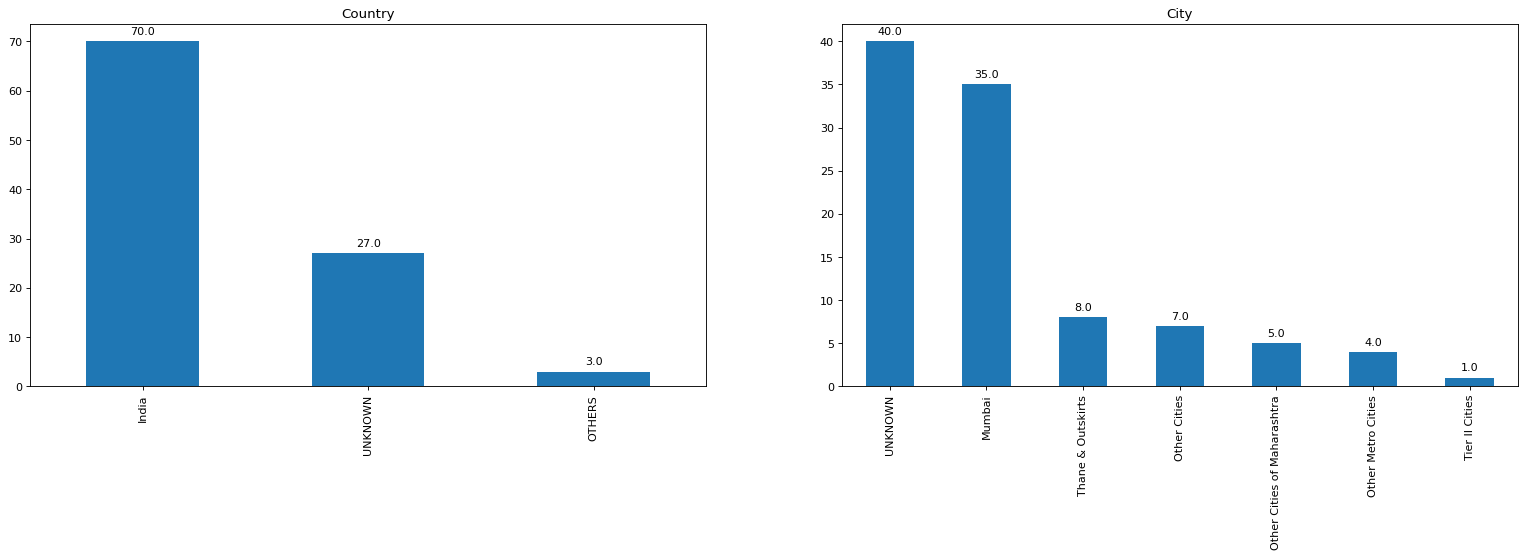

In [6924]:
plt.figure(figsize=(24, 6), dpi=80)
ax = plt.subplot(1, 2, 1); utils.valueCounts(df, 'Country',ax)
ax = plt.subplot(1, 2, 2); utils.valueCounts(df, 'City', ax)

We can derive the Country from City column where the values are ('Thane & Outskirts', 'Other Cities of Maharashtra', 'Mumbai'). 

In [6925]:
count_india_derive = df[(df['Country'].isnull()) & (~df['City'].isnull()) & (df['City'].isin(['Thane & Outskirts', 'Other Cities of Maharashtra', 'Mumbai']))]['City'].shape[0]
print(count_india_derive)
count_india += count_india_derive
print(count_india, count_nonindia, count_null)
print(round(100 * count_india/df.shape[0],2), round(100 * count_nonindia/df.shape[0],2), round(100 * count_null/df.shape[0],2))

0
6492 2748 0
70.26 29.74 0.0


For 2461 rows Country is null and only very few countries are outside india, precisely only 287 i.e. only 3% of data. If we impute India as missing values, then majority data would only be India and thiss column would add no significance to analysis. So let us drop Country.

In [6926]:
df_country = df.groupby(by=['City', 'Country']).agg({'City':'count'})
df_country.rename(columns={'City':'Count'}, inplace=True)
pd.pivot_table(df_country,index='Country', columns=['City'], )

Count                                                              \
City    Mumbai Other Cities Other Cities of Maharashtra Other Metro Cities   
Country                                                                      
India     2918          564                         391                345   
OTHERS      93           67                          23                 20   
UNKNOWN    211           55                          43                 15   

                                                 
City    Select Thane & Outskirts Tier II Cities  
Country                                          
India      999               651             69  
OTHERS      33                21              3  
UNKNOWN   1217                80              2

Many countries (not India) have City as "'Thane & Outskirts', 'Other Cities of Maharashtra', 'Mumbai' which is incorrect. So we should drop City.

In [6927]:
print("Before: ", df.shape ,end=' '); df.drop(columns='City', inplace=True); print("After: ", df.shape ,end=' ')

Before:  (9240, 36) After:  (9240, 35) 

| Column Name | Missing values? | Handling |
|---|---|---|
| Country | 26% | 27% values of Country is null and only 3% countries are outside india, If we impute India as missing values, then majority data would only be India and this column would add no significance to analysis. So keep the Missing values as a different category "UNKNOWN"|
| City |  | Many countries (not India) have City as "'Thane & Outskirts', 'Other Cities of Maharashtra', 'Mumbai' which is incorrect. So we should drop City. | 

### COLUMNS - PROF

In [6928]:
df[COLS_PROF][:5]

,Occupation,Specialization,Reason
0,Unemployed,Select,Better Career Prospects
1,Unemployed,Select,Better Career Prospects
2,Student,Business Administration,Better Career Prospects
3,Unemployed,Media and Advertising,Better Career Prospects
4,Unemployed,Select,Better Career Prospects


In [6929]:
utils.showColumns(df, COLS_PROF)

Occupation: object  : 2690, 29.1% :    7, 0.1% : ['nan', 'Businessman', 'Housewife', 'Other', 'Student', 'Unemployed', 'Working Professional']
Specialization: object  : 1438, 15.6% :   20, 0.2% : ['nan', 'Banking, Investment And Insurance', 'Business Administration', 'E-Business', 'E-COMMERCE', 'Finance Management', 'Healthcare Management', 'Hospitality Management', 'Human Resource Management', 'IT Projects Management', 'International Business', 'Marketing Management', 'Media and Advertising', 'Operations Management', 'Retail Management', 'Rural and Agribusiness', 'Select', 'Services Excellence', 'Supply Chain Management', 'Travel and Tourism']
Reason    : object  : 2709, 29.3% :    4, 0.0% : ['nan', 'Better Career Prospects', 'Flexibility & Convenience', 'Other']


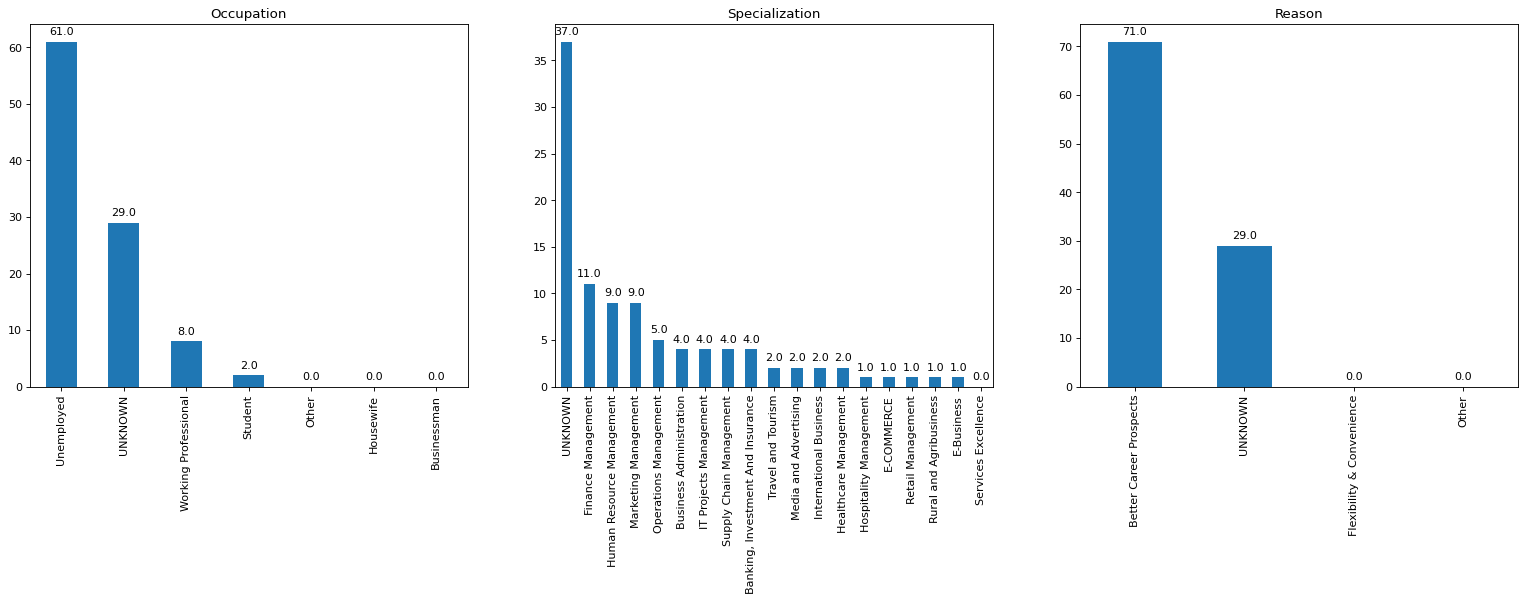

In [6930]:
plt.figure(figsize=(24, 6), dpi=80)
ax = plt.subplot(1, 3, 1); utils.valueCounts(df, 'Occupation',ax)
ax = plt.subplot(1, 3, 2); utils.valueCounts(df, 'Specialization', ax)
ax = plt.subplot(1, 3, 3); utils.valueCounts(df, 'Reason', ax)

In [6931]:
for col in COLS_PROF:
    df[col].replace('Select','UNKNOWN', inplace=True)
    df[col] = df[col].fillna('UNKNOWN')

# Group to less freuqnetly occurring values as OTHERS
#df['Occupation'] = df['Occupation'].apply(lambda x: x if x in ['Unemployed', 'Working Professional', 'UNKNOWN'] else 'OTHERS')
#df['Specialization'] = df['Specialization'].apply(lambda x: x if x in ['Finance Management', 'Human Resource Management', 'Marketing Management', 'UNKNOWN'] else 'OTHERS')
df['Reason'] = df['Reason'].apply(lambda x: x if x in ['Better Career Prospects', 'UNKNOWN'] else 'OTHERS')

In [6932]:
utils.showColumns(df, COLS_PROF)

Occupation: object  :    0, 0.0% :    7, 0.1% : ['Businessman', 'Housewife', 'Other', 'Student', 'UNKNOWN', 'Unemployed', 'Working Professional']
Specialization: object  :    0, 0.0% :   19, 0.2% : ['Banking, Investment And Insurance', 'Business Administration', 'E-Business', 'E-COMMERCE', 'Finance Management', 'Healthcare Management', 'Hospitality Management', 'Human Resource Management', 'IT Projects Management', 'International Business', 'Marketing Management', 'Media and Advertising', 'Operations Management', 'Retail Management', 'Rural and Agribusiness', 'Services Excellence', 'Supply Chain Management', 'Travel and Tourism', 'UNKNOWN']
Reason    : object  :    0, 0.0% :    3, 0.0% : ['Better Career Prospects', 'OTHERS', 'UNKNOWN']


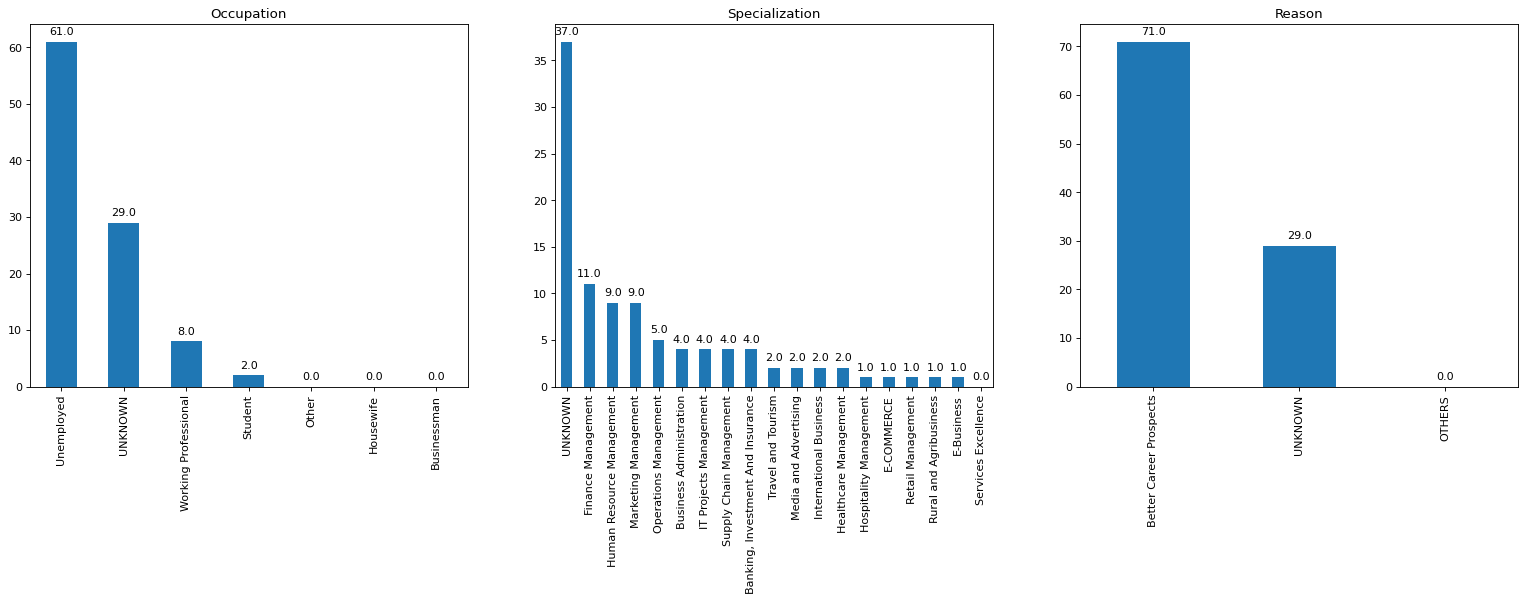

In [6933]:
plt.figure(figsize=(24, 6), dpi=80)
ax = plt.subplot(1, 3, 1); utils.valueCounts(df, 'Occupation',ax)
ax = plt.subplot(1, 3, 2); utils.valueCounts(df, 'Specialization', ax)
ax = plt.subplot(1, 3, 3); utils.valueCounts(df, 'Reason', ax)

Around 29% rows have null Reason. We can impute the Reason with 'Better Career Prospects'. But then only .03% rows have Reason other than 'Better Career Prospects'. So the column Reason will add no significance to the model. So drop the column Reason

In [6934]:
utils.dropColumns(df, 'Reason', ['Reason'])

Drop Reason 1 columns: Shape - before (9240, 35) Shape - after (9240, 34)


| Column Name | Missing values? | Handling |
|---|---|---|
| Occupation | 29% | Replace missing values as UNKNOWN. Group categories <=5% as OTHERS |
| Specialization | 15.6% | Replace missing values as UNKNOWN. Group categories <=5% as OTHERS |
| Reason | 29% | Around 29% rows have null Reason. We can impute the Reason with 'Better Career Prospects'. But then only .03% rows have Reason other than 'Better Career Prospects'. So the column Reason will add no significance to the model. So drop the column Reason |

### COLUMNS - AD

In [6935]:
utils.showColumns(df, COLS_AD)

Found     : object  : 2207, 23.9% :   11, 0.1% : ['nan', 'Advertisements', 'Email', 'Multiple Sources', 'Online Search', 'Other', 'SMS', 'Select', 'Social Media', 'Student of SomeSchool', 'Word Of Mouth']
AdSearch  : object  :    0, 0.0% :    2, 0.0% : ['No', 'Yes']
AdMagazine: object  :    0, 0.0% :    1, 0.0% : ['No']
AdNewspaperArticle: object  :    0, 0.0% :    2, 0.0% : ['No', 'Yes']
AdForums  : object  :    0, 0.0% :    2, 0.0% : ['No', 'Yes']
AdNewspaper: object  :    0, 0.0% :    2, 0.0% : ['No', 'Yes']
AdDigital : object  :    0, 0.0% :    2, 0.0% : ['No', 'Yes']
Recommendations: object  :    0, 0.0% :    2, 0.0% : ['No', 'Yes']


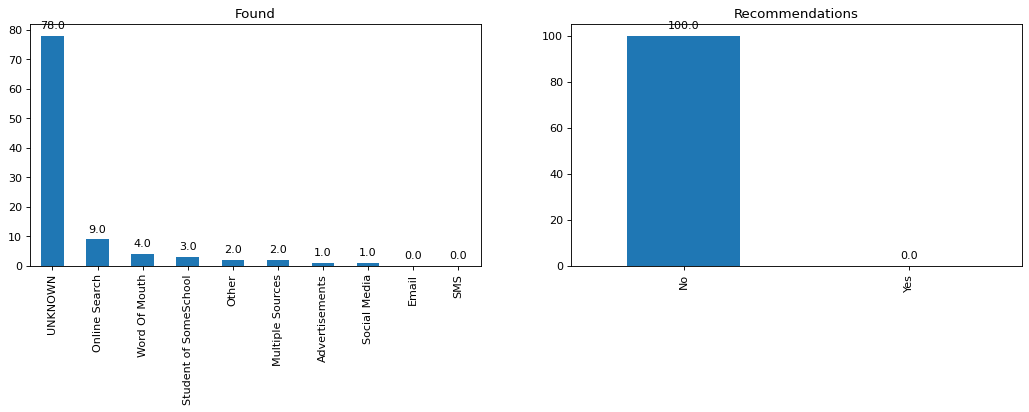

In [6936]:
plt.figure(figsize=(16, 4), dpi=80)

ax = plt.subplot(1, 2, 1); utils.valueCounts(df, 'Found',ax)
ax = plt.subplot(1, 2, 2); utils.valueCounts(df, 'Recommendations',ax)

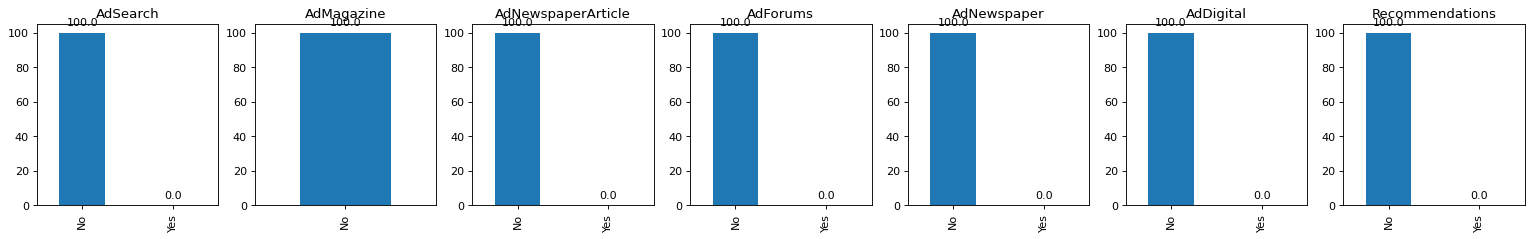

In [6937]:
plt.figure(figsize=(24, 3), dpi=80)
ax = plt.subplot(1, 7, 1); utils.valueCounts(df, 'AdSearch',ax)
ax = plt.subplot(1, 7, 2); utils.valueCounts(df, 'AdMagazine', ax)
ax = plt.subplot(1, 7, 3); utils.valueCounts(df, 'AdNewspaperArticle', ax)
ax = plt.subplot(1, 7, 4); utils.valueCounts(df, 'AdForums', ax)
ax = plt.subplot(1, 7, 5); utils.valueCounts(df, 'AdNewspaper', ax)
ax = plt.subplot(1, 7, 6); utils.valueCounts(df, 'AdDigital', ax)
ax = plt.subplot(1, 7, 7); utils.valueCounts(df, 'Recommendations', ax)

In [6938]:
for col in COLS_AD:
    df[col].replace('Select','UNKNOWN', inplace=True)
    df[col] = df[col].fillna('UNKNOWN')

df['Found'] = df['Found'].apply(lambda x: x if x in ['Online Search', 'UNKNOWN'] else 'OTHERS')

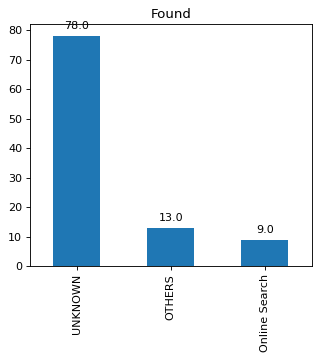

In [6939]:
plt.figure(figsize=(10, 4), dpi=80)
ax = plt.subplot(1, 2, 1); utils.valueCounts(df, 'Found',ax)

In [6940]:
utils.dropColumns(df, 'COLS_AD', list(set(COLS_AD)-{'Found'}))

Drop COLS_AD 7 columns: Shape - before (9240, 34) Shape - after (9240, 27)


| Column Name | Missing values - NaN + Select | Handling |
|---|---|---|
| Found | 70% | Group NaN as UNKNOWN and categories with <=5% as OTHERS  |
| AdXXX | - | Remove Column as almost all rows have the same value 'No' |
| Recommendations | - | Remove Column as almost all rows have the same value 'No' |

### COLUMNS - PREF
Preferences of the lead

In [6941]:
utils.showColumns(df, COLS_PREF)

NoEmail   : object  :    0, 0.0% :    2, 0.0% : ['No', 'Yes']
NoCall    : object  :    0, 0.0% :    2, 0.0% : ['No', 'Yes']
CourseUpdates: object  :    0, 0.0% :    1, 0.0% : ['No']
SCCUpdates: object  :    0, 0.0% :    1, 0.0% : ['No']
DMCUpdates: object  :    0, 0.0% :    1, 0.0% : ['No']
FreeCopy  : object  :    0, 0.0% :    2, 0.0% : ['No', 'Yes']
PayAmount : object  :    0, 0.0% :    1, 0.0% : ['No']


In [6942]:
for col in COLS_PREF:
    print(col, df[col].value_counts().to_list())

NoEmail [8506, 734]
NoCall [9238, 2]
CourseUpdates [9240]
SCCUpdates [9240]
DMCUpdates [9240]
FreeCopy [6352, 2888]
PayAmount [9240]


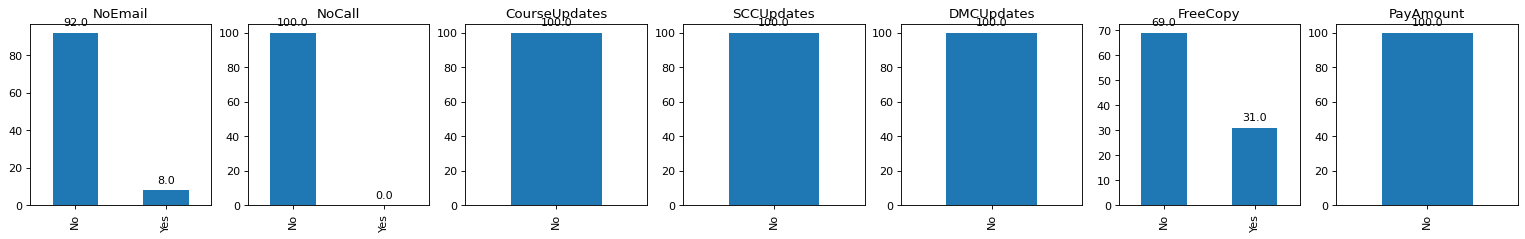

In [6943]:
plt.figure(figsize=(24, 3), dpi=80)
ax = plt.subplot(1, 7, 1); utils.valueCounts(df, 'NoEmail',ax)
ax = plt.subplot(1, 7, 2); utils.valueCounts(df, 'NoCall', ax)
ax = plt.subplot(1, 7, 3); utils.valueCounts(df, 'CourseUpdates', ax)
ax = plt.subplot(1, 7, 4); utils.valueCounts(df, 'SCCUpdates', ax)
ax = plt.subplot(1, 7, 5); utils.valueCounts(df, 'DMCUpdates', ax)
ax = plt.subplot(1, 7, 6); utils.valueCounts(df, 'FreeCopy', ax)
ax = plt.subplot(1, 7, 7); utils.valueCounts(df, 'PayAmount', ax)

In [6944]:
utils.dropColumns(df,  "COLS_PREF", list(set(COLS_PREF)-{'NoEmail', 'FreeCopy'}))

Drop COLS_PREF 5 columns: Shape - before (9240, 27) Shape - after (9240, 22)


Converted      0      1
NoEmail                
No         54.79  37.26
Yes         6.67   1.28
Converted      0      1
FreeCopy               
No         41.35  27.39
Yes        20.11  11.15


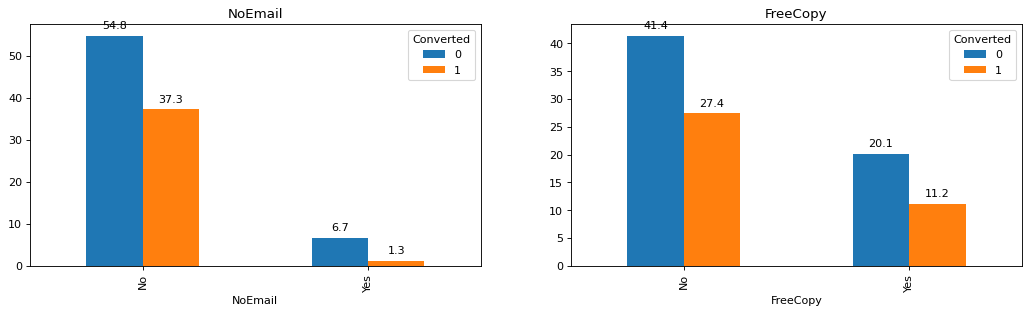

In [6945]:
df_noemail = df[['NoEmail','Converted']].groupby(by=['NoEmail','Converted']).agg({'NoEmail':'count'}).rename(columns={'NoEmail':'Count'})
df_noemail.reset_index(inplace=True)
df_noemail = pd.pivot_table(df_noemail, index='NoEmail', columns='Converted', values='Count')
df_noemail = utils.percent(df_noemail, df.shape[0]); print(df_noemail)

df_freecopy = df[['FreeCopy','Converted']].groupby(by=['FreeCopy','Converted']).agg({'FreeCopy':'count'}).rename(columns={'FreeCopy':'Count'})
df_freecopy.reset_index(inplace=True)
df_freecopy = pd.pivot_table(df_freecopy, index='FreeCopy', columns='Converted', values='Count')
df_freecopy = utils.percent(df_freecopy, df.shape[0]); print(df_freecopy)

plt.figure(figsize=(16, 4), dpi=80)
ax = plt.subplot(1, 2, 1); ax = df_noemail.plot.bar(ax=ax); utils.annotate(ax, 'NoEmail')
ax = plt.subplot(1, 2, 2); ax = df_freecopy.plot.bar(ax=ax); utils.annotate(ax, 'FreeCopy')

| Column Name | Missing values? | Handling |
|---|---|---|
| XXX |  - | Remove as almost all rows have the same value 'No' |
| NoEmail |  - | - |
| FreeCopy |  - | - |

### COLUMNS - ACTIVITY
Activity of the lead - Indicator of candidate's interest.
- Visits, Time spent: Higher the value, higher is the interest
- Last Activity & Last Notable Activity have the same values except 'Converted to Lead' of Last Activity. What is the difference? 
- Visits to the site and time spent on the website

In [6946]:
df[(df['LastActivity'].isnull()) & (df['Converted']==1)][['LastActivity', 'LastNotableActivity','Converted']]

,LastActivity,LastNotableActivity,Converted
77,NaN,Modified,1
79,NaN,Modified,1
81,NaN,Modified,1
88,NaN,Modified,1
120,NaN,Modified,1
...,...,...,...
8081,NaN,Modified,1
8107,NaN,Modified,1
8434,NaN,Modified,1
9015,NaN,Modified,1


In [6947]:
utils.showColumns(df, COLS_ACTIVTIY)

TotalVisits: float64 :  137, 1.5% : 3 [0.0, 1.0, 3.0, 5.0, 251.0] 
PageViews : float64 :  137, 1.5% : 2 [0.0, 1.0, 2.0, 3.0, 55.0] 
TimeSpent : int64   :    0, 0.0% : 488 [0.0, 12.0, 248.0, 936.0, 2272.0] 
LastActivity: object  :  103, 1.1% :   18, 0.2% : ['nan', 'Approached upfront', 'Converted to Lead', 'Email Bounced', 'Email Link Clicked', 'Email Marked Spam', 'Email Opened', 'Email Received', 'Form Submitted on Website', 'Had a Phone Conversation', 'Olark Chat Conversation', 'Page Visited on Website', 'Resubscribed to emails', 'SMS Sent', 'Unreachable', 'Unsubscribed', 'View in browser link Clicked', 'Visited Booth in Tradeshow']
LastNotableActivity: object  :    0, 0.0% :   16, 0.2% : ['Approached upfront', 'Email Bounced', 'Email Link Clicked', 'Email Marked Spam', 'Email Opened', 'Email Received', 'Form Submitted on Website', 'Had a Phone Conversation', 'Modified', 'Olark Chat Conversation', 'Page Visited on Website', 'Resubscribed to emails', 'SMS Sent', 'Unreachable', 'Unsubs

In [6948]:
print(set(df['LastActivity'].unique())-set(df['LastNotableActivity'].unique()))
print(set(df['LastNotableActivity'].unique())-set(df['LastActivity'].unique()))

{nan, 'Converted to Lead', 'Visited Booth in Tradeshow'}
{'Modified'}


TODO: What does modified signify?

<AxesSubplot:title={'center':'TimeSpent'}, xlabel='Converted'>

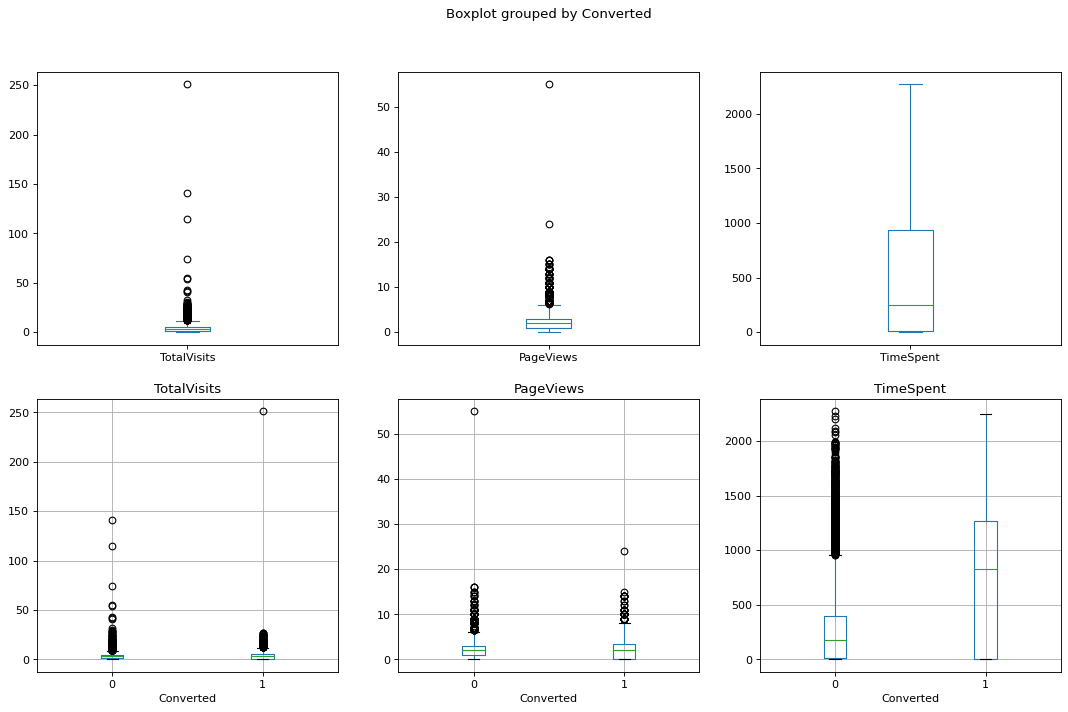

In [6949]:
plt.figure(figsize=(16, 10), dpi=80)

ax = plt.subplot(2, 3, 1); df['TotalVisits'].plot.box(ax=ax)
ax = plt.subplot(2, 3, 2); df['PageViews'].plot.box(ax=ax)
ax = plt.subplot(2, 3, 3); df['TimeSpent'].plot.box(ax=ax)

ax = plt.subplot(2, 3, 4); df.boxplot(column=['TotalVisits'], by='Converted', ax=ax) 
ax = plt.subplot(2, 3, 5); df.boxplot(column=['PageViews'], by='Converted', ax=ax) 
ax = plt.subplot(2, 3, 6); df.boxplot(column=['TimeSpent'], by='Converted', ax=ax)

In [6950]:
# There are outliers, so we can either remove the rows with missing values or impute the missing values by median
df['TotalVisits'].fillna(df['TotalVisits'].median(), inplace=True)
df['PageViews'].fillna(df['PageViews'].median(), inplace=True)

<AxesSubplot:title={'center':'TimeSpent'}, xlabel='Converted'>

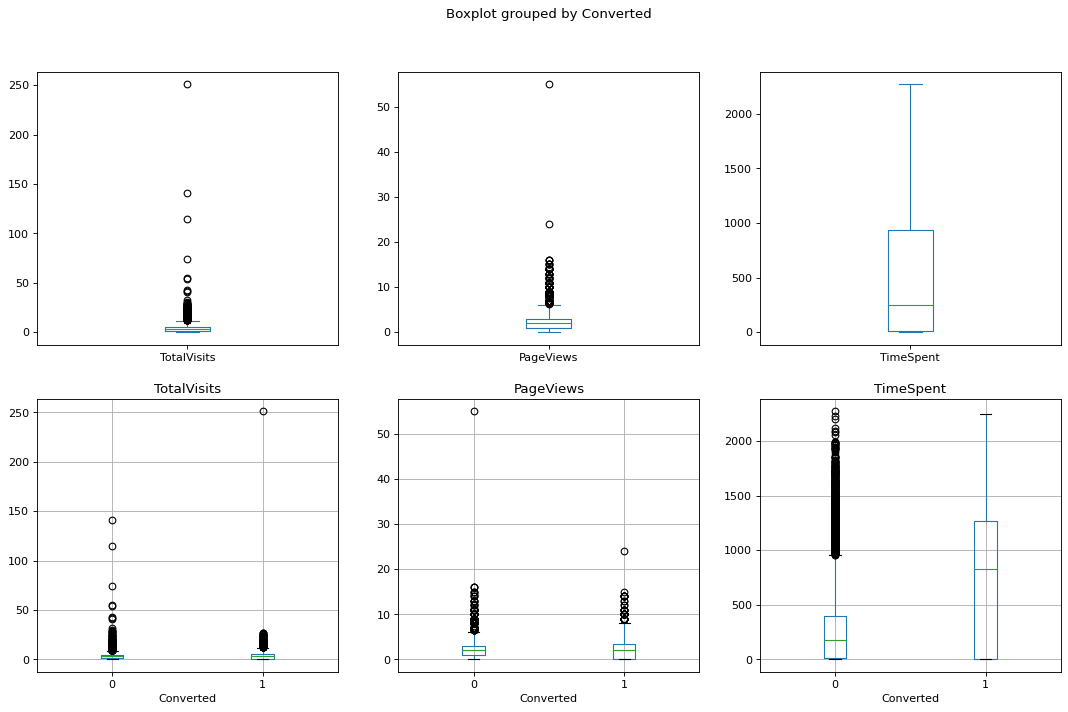

In [6951]:
plt.figure(figsize=(16, 10), dpi=80)

ax = plt.subplot(2, 3, 1); df['TotalVisits'].plot.box(ax=ax)
ax = plt.subplot(2, 3, 2); df['PageViews'].plot.box(ax=ax)
ax = plt.subplot(2, 3, 3); df['TimeSpent'].plot.box(ax=ax)

ax = plt.subplot(2, 3, 4); df.boxplot(column=['TotalVisits'], by='Converted', ax=ax) 
ax = plt.subplot(2, 3, 5); df.boxplot(column=['PageViews'], by='Converted', ax=ax) 
ax = plt.subplot(2, 3, 6); df.boxplot(column=['TimeSpent'], by='Converted', ax=ax)

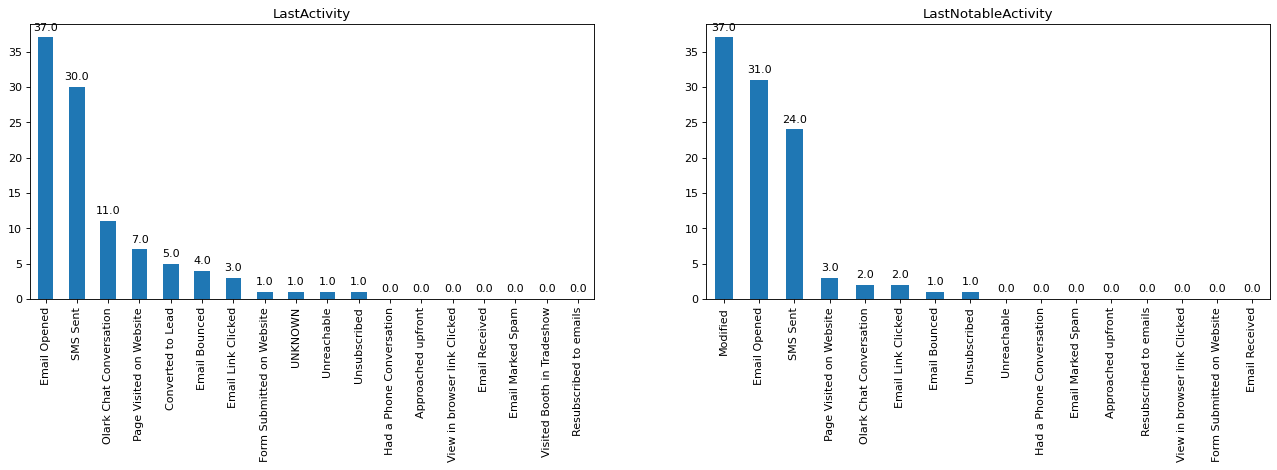

In [6952]:
plt.figure(figsize=(20, 10), dpi=80)
ax = plt.subplot(2, 2, 1); utils.valueCounts(df, 'LastActivity',ax) 
ax = plt.subplot(2, 2, 2); utils.valueCounts(df, 'LastNotableActivity',ax) 

In [6953]:
print("Values in LastActivity but not in LastNotableActivity", list(set(df['LastActivity'].unique().tolist())-set(df['LastNotableActivity'].unique().tolist())))
print("Values in LastNotableActivity but not in LastActivity", list(set(df['LastNotableActivity'].unique().tolist())-set(df['LastActivity'].unique().tolist())))

Values in LastActivity but not in LastNotableActivity [nan, 'Converted to Lead', 'Visited Booth in Tradeshow']
Values in LastNotableActivity but not in LastActivity ['Modified']


In [6954]:
df[df['LastActivity']=='Converted to Lead'][['LastActivity','Converted']].groupby(by=['Converted']).agg({'Converted':'count'})

,Converted
Converted,
0,374
1,54


In [6955]:
df[['LastActivity','LastNotableActivity', 'Converted']]

,LastActivity,LastNotableActivity,Converted
0,Page Visited on Website,Modified,0
1,Email Opened,Email Opened,0
2,Email Opened,Email Opened,1
3,Unreachable,Modified,0
4,Converted to Lead,Modified,1
...,...,...,...
9235,Email Marked Spam,Email Marked Spam,1
9236,SMS Sent,SMS Sent,0
9237,SMS Sent,SMS Sent,0
9238,SMS Sent,SMS Sent,1


In [6956]:
df[df['LastActivity']==df['LastNotableActivity']][['LastActivity','LastNotableActivity', 'Converted']]

,LastActivity,LastNotableActivity,Converted
1,Email Opened,Email Opened,0
2,Email Opened,Email Opened,1
8,Email Opened,Email Opened,0
9,Email Opened,Email Opened,0
10,Email Opened,Email Opened,1
...,...,...,...
9233,SMS Sent,SMS Sent,1
9235,Email Marked Spam,Email Marked Spam,1
9236,SMS Sent,SMS Sent,0
9237,SMS Sent,SMS Sent,0


In [6957]:
print(df[df['LastActivity']!=df['LastNotableActivity']][['LastActivity','LastNotableActivity', 'Converted']].shape[0], "\n\n",
        df[(df['LastActivity']!=df['LastNotableActivity'])][['LastActivity']].value_counts(), "\n\n",
        df[(df['LastActivity']!=df['LastNotableActivity'])][['LastNotableActivity']].value_counts() )

3407 

 LastActivity                
Olark Chat Conversation         790
Email Opened                    610
SMS Sent                        573
Converted to Lead               428
Page Visited on Website         322
Email Bounced                   266
Form Submitted on Website       115
Email Link Clicked               94
Unreachable                      61
Had a Phone Conversation         16
Unsubscribed                     14
Approached upfront                8
View in browser link Clicked      5
Email Received                    1
Visited Booth in Tradeshow        1
dtype: int64 

 LastNotableActivity
Modified               3407
dtype: int64


In [6958]:
df[(df['LastActivity'].isnull())][['LastNotableActivity']].value_counts()

LastNotableActivity
Modified               103
dtype: int64

- In the cases where LastActivity and LastNotableActivity are not equal, the LastNotableActivity is always "Modified'. We can retain 'LastActivity' and drop 'LastNotableActivity'
- In the cases where LastActivity is null, the LastNotableActivity is always "Modified'. We can retain 'LastActivity' and drop 'LastNotableActivity'

In [6959]:
utils.dropColumns(df,  "COLS_ACTIVITY", ['LastNotableActivity'])

Drop COLS_ACTIVITY 1 columns: Shape - before (9240, 22) Shape - after (9240, 21)


In [6960]:
print(f"LastActivity - Before {df.shape}", end=' '); df = df[~df['LastActivity'].isnull()]; print(f"After {df.shape}")

LastActivity - Before (9240, 21) After (9137, 21)


In [6961]:
df['LastActivity'].value_counts().index

Index(['Email Opened', 'SMS Sent', 'Olark Chat Conversation',
       'Page Visited on Website', 'Converted to Lead', 'Email Bounced',
       'Email Link Clicked', 'Form Submitted on Website', 'Unreachable',
       'Unsubscribed', 'Had a Phone Conversation', 'Approached upfront',
       'View in browser link Clicked', 'Email Received', 'Email Marked Spam',
       'Visited Booth in Tradeshow', 'Resubscribed to emails'],
      dtype='object')

In [6962]:
# Group to less freuqnetly occurring values as OTHERS
# df['LastActivity'] = df['LastActivity'].apply(lambda x: x if x in ['Email Opened', 'SMS Sent', 'Olark Chat Conversation',
#       'Page Visited on Website', 'Converted to Lead'] else 'OTHERS')

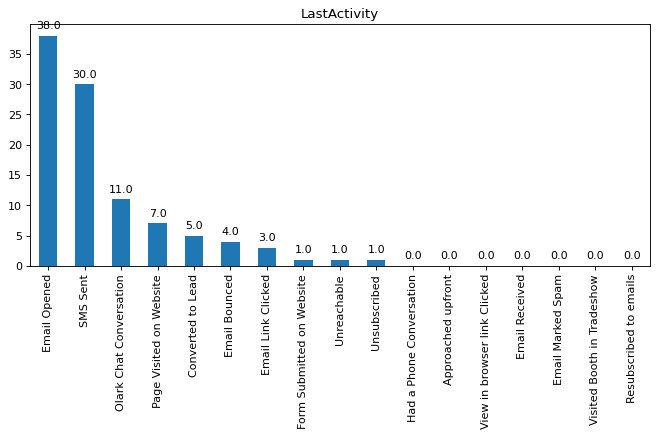

In [6963]:
plt.figure(figsize=(10, 4), dpi=80)
utils.valueCounts(df, 'LastActivity') 

| Column Name | Missing values? | Select? | Handling |
|---|---|---|---|
| TotalVisits | 1.5% | - | Impute with median |
| PageViews | 1.5% | - | Impute with median |
| TimeSpent | -  | - | - |
| LastActivity |  1.1% | -  | Remove the rows with null values  or Impute it with mode|
| LastNotableActivity | - | - | - |

Note: LastActivity & LastNotableActivity differ in 2 values - nan,  'Converted to Lead'

### COLUMNS - LEAD
Lead related data - Where was the customer identified as a lead? Source, quality and level/profile of the lead


In [6964]:
utils.showColumns(df, COLS_LEAD)

LeadNumber: int64   :    0, 0.0% : 617060 [579533.0, 596412.0, 615320.0, 637189.0, 660737.0] 
LeadOrigin: object  :    0, 0.0% :    5, 0.1% : ['API', 'Landing Page Submission', 'Lead Add Form', 'Lead Import', 'Quick Add Form']
LeadSource: object  :   34, 0.4% :   22, 0.2% : ['nan', 'Click2call', 'Direct Traffic', 'Facebook', 'Google', 'Live Chat', 'NC_EDM', 'Olark Chat', 'Organic Search', 'Pay per Click Ads', 'Press_Release', 'Reference', 'Referral Sites', 'Social Media', 'WeLearn', 'Welingak Website', 'bing', 'blog', 'google', 'testone', 'welearnblog_Home', 'youtubechannel']
LeadQuality: object  : 4742, 51.9% :    6, 0.1% : ['nan', 'High in Relevance', 'Low in Relevance', 'Might be', 'Not Sure', 'Worst']
LeadProfile: object  : 2709, 29.6% :    7, 0.1% : ['nan', 'Dual Specialization Student', 'Lateral Student', 'Other Leads', 'Potential Lead', 'Select', 'Student of SomeSchool']
Tags      : object  : 3344, 36.6% :   27, 0.3% : ['nan', 'Already a student', 'Busy', 'Closed by Horizzon', '

In [6965]:
# LeadSource has Google and google. These can be combined into 1
df['LeadSource'] = df['LeadSource'].apply(lambda x: 'Google' if x == 'google' else x)

In [6966]:
utils.showColumns(df, COLS_LEAD)

LeadNumber: int64   :    0, 0.0% : 617060 [579533.0, 596412.0, 615320.0, 637189.0, 660737.0] 
LeadOrigin: object  :    0, 0.0% :    5, 0.1% : ['API', 'Landing Page Submission', 'Lead Add Form', 'Lead Import', 'Quick Add Form']
LeadSource: object  :   34, 0.4% :   21, 0.2% : ['nan', 'Click2call', 'Direct Traffic', 'Facebook', 'Google', 'Live Chat', 'NC_EDM', 'Olark Chat', 'Organic Search', 'Pay per Click Ads', 'Press_Release', 'Reference', 'Referral Sites', 'Social Media', 'WeLearn', 'Welingak Website', 'bing', 'blog', 'testone', 'welearnblog_Home', 'youtubechannel']
LeadQuality: object  : 4742, 51.9% :    6, 0.1% : ['nan', 'High in Relevance', 'Low in Relevance', 'Might be', 'Not Sure', 'Worst']
LeadProfile: object  : 2709, 29.6% :    7, 0.1% : ['nan', 'Dual Specialization Student', 'Lateral Student', 'Other Leads', 'Potential Lead', 'Select', 'Student of SomeSchool']
Tags      : object  : 3344, 36.6% :   27, 0.3% : ['nan', 'Already a student', 'Busy', 'Closed by Horizzon', 'Diploma ho

In [6967]:
print('LeadSource', df[df['LeadSource'].isnull()]['Converted'].value_counts())
print('LeadQuality', df[df['LeadQuality'].isnull()]['Converted'].value_counts())
print('LeadProfile', df[df['LeadProfile'].isnull()]['Converted'].value_counts())
print('Tags', df[df['Tags'].isnull()]['Converted'].value_counts())

LeadSource 1    28
0     6
Name: Converted, dtype: int64
LeadQuality 0    3736
1    1006
Name: Converted, dtype: int64
LeadProfile 0    2339
1     370
Name: Converted, dtype: int64
Tags 0    2516
1     828
Name: Converted, dtype: int64


- LeadSource:  Has very less missing values. The rows can be removed.
- LeadQuality: Has lot of missing values. The column can be removed.

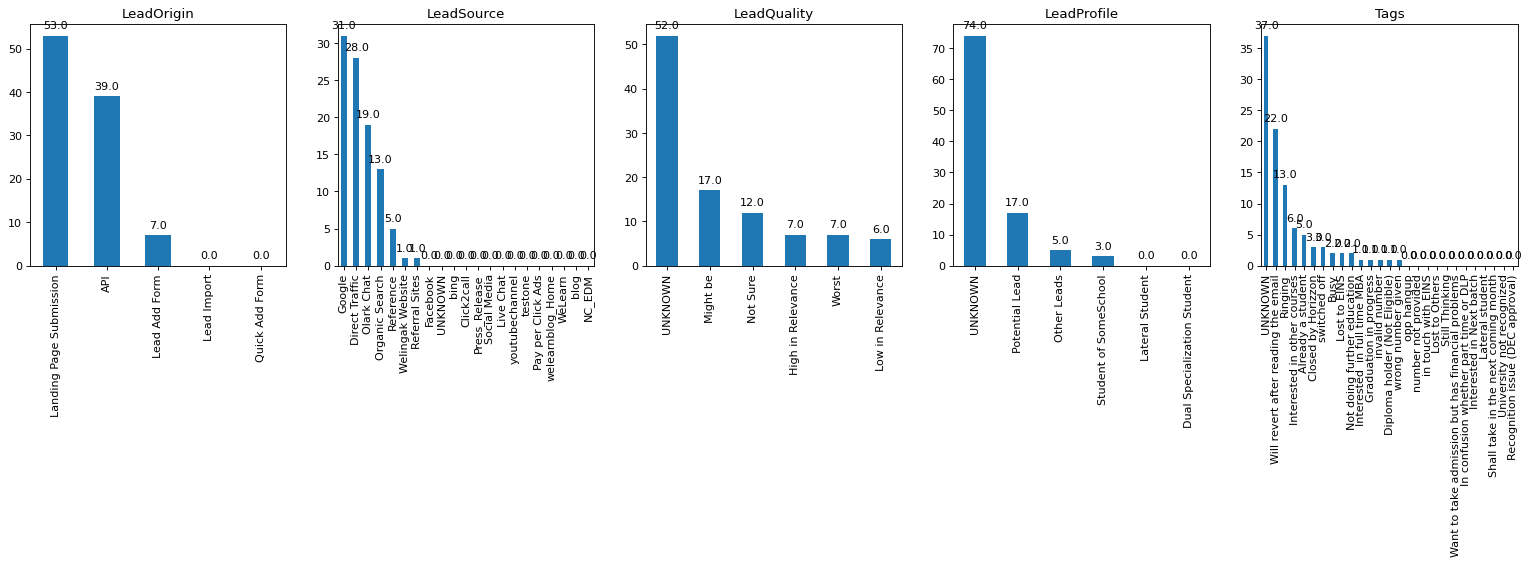

In [6968]:
plt.figure(figsize=(24, 4), dpi=80)
ax = plt.subplot(1, 5, 1); utils.valueCounts(df, 'LeadOrigin',ax)
ax = plt.subplot(1, 5, 2); utils.valueCounts(df, 'LeadSource',ax)
ax = plt.subplot(1, 5, 3); utils.valueCounts(df, 'LeadQuality', ax)
ax = plt.subplot(1, 5, 4); utils.valueCounts(df, 'LeadProfile', ax)
ax = plt.subplot(1, 5, 5); utils.valueCounts(df, 'Tags', ax)

In [6969]:
#  'Direct Traffic', 'Google',   'Olark Chat', 'Organic Search',
LEAD_SOURCE_LT_5 = ['Welingak Website', 'Referral Sites',  'Facebook', 'UNKNOWN', 'bing', 'Click2call', 'Press_Release', 'Social Media', 'Live Chat',  'youtubechannel', 'testone',  'Pay per Click Ads', 'welearnblog_Home', 'WeLearn',  'blog', 'NC_EDM']
df['LeadSource']= df['LeadSource'].fillna('UNKNOWN')
df['LeadSource'].replace('Select','UNKNOWN', inplace=True)

# Group to less freuqnetly occurring values as OTHERS
#df['LeadSource'] = df['LeadSource'].apply(lambda x: 'OTHERS' if x in LEAD_SOURCE_LT_5 else x)

In [6970]:
#  'Direct Traffic', 'Google',   'Olark Chat', 'Organic Search',
df['LeadProfile']= df['LeadProfile'].fillna('UNKNOWN')
df['LeadProfile'].replace('Select','UNKNOWN', inplace=True)
#df['LeadProfile'] = df['LeadProfile'].apply(lambda x: 'Student' if 'Student' in x else x)

In [6971]:
# Group to less freuqnetly occurring values as OTHERS
TAGS_GT_5 = ['UNKNOWN', 'Will revert after reading the email', 'Ringing', 'Interested in other courses',  'Already a student']
df['Tags']= df['Tags'].fillna('UNKNOWN')
df['Tags'].replace('Select','UNKNOWN', inplace=True)
#df['Tags'] = df['Tags'].apply(lambda x: x if x in TAGS_GT_5 else 'OTHERS')

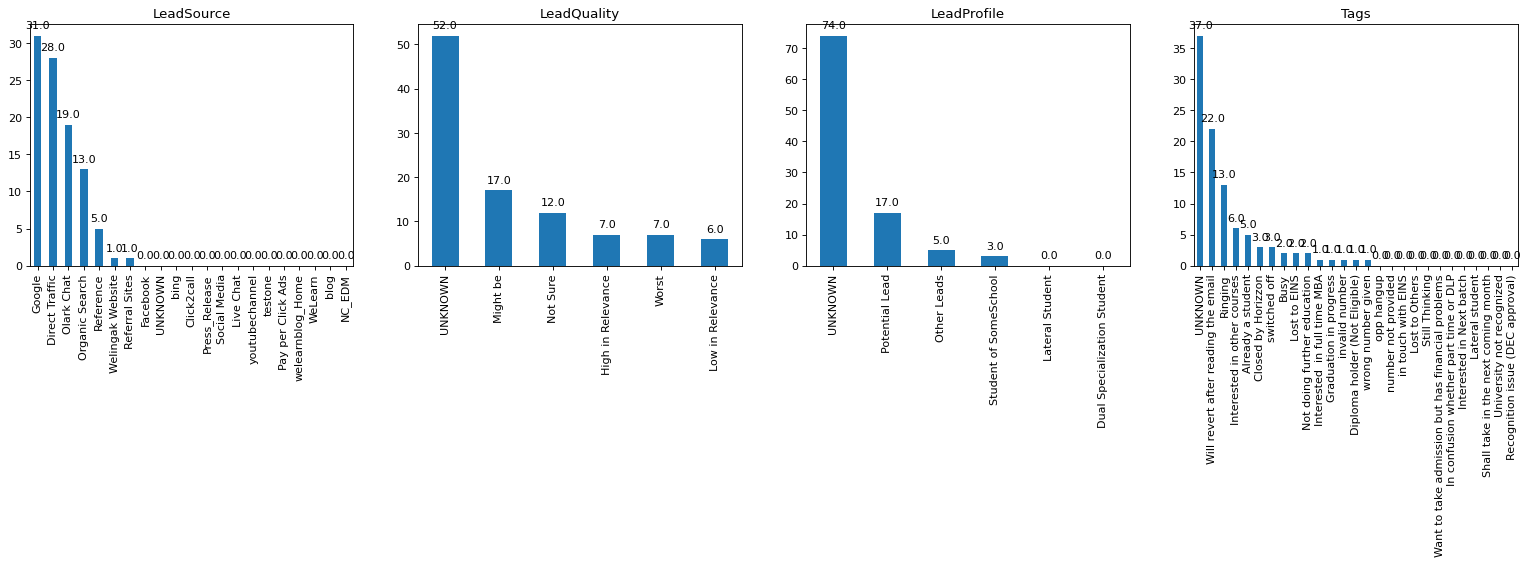

In [6972]:
plt.figure(figsize=(24, 4), dpi=80)
ax = plt.subplot(1, 4, 1); utils.valueCounts(df, 'LeadSource',ax)
ax = plt.subplot(1, 4, 2); utils.valueCounts(df, 'LeadQuality', ax)
ax = plt.subplot(1, 4, 3); utils.valueCounts(df, 'LeadProfile', ax)
ax = plt.subplot(1, 4, 4); utils.valueCounts(df, 'Tags', ax)

In [6973]:
# 'LeadProfile' has high number of missing values. LeadNumber is an Id. So dropping both
# utils.dropColumns(df, 'COLS_LEAD', ['LeadNumber', 'LeadProfile'])

# Drop tags also. As including it gives a bad test accuracy and sensitivity
utils.dropColumns(df, 'COLS_LEAD', ['LeadNumber', 'LeadProfile', 'Tags'])

Drop COLS_LEAD 3 columns: Shape - before (9137, 21) Shape - after (9137, 18)


| Column Name | Missing values? | Handling |
|---|---|---|
| LeadNumber | - | Drop as this is an ID |
| LeadOrigin | - | - |
| LeadSource | 0.4% | - |
| LeadQuality | 51.6% | |
| LeadProfile | 29.3% | |
| Tags | 36.3% | |


### COLUMNS - INDEXSCORE

In [6974]:
utils.showColumns(df, COLS_INDEXSCORE)

ActivityIndex: object  : 4175, 45.7% :    4, 0.0% : ['nan', '01.High', '02.Medium', '03.Low']
ProfileIndex: object  : 4175, 45.7% :    4, 0.0% : ['nan', '01.High', '02.Medium', '03.Low']
ActivityScore: float64 : 4175, 45.7% : 14 [7.0, 14.0, 14.0, 15.0, 18.0] 
ProfileScore: float64 : 4175, 45.7% : 16 [11.0, 15.0, 16.0, 18.0, 20.0] 


The number of missing values is quite high. Drop these columns

In [6975]:
utils.dropColumns(df, 'COLS_INDEXSCORE', COLS_INDEXSCORE)

Drop COLS_INDEXSCORE 4 columns: Shape - before (9137, 18) Shape - after (9137, 14)


| Column Name | Missing values? | Select? | Handling |
|---|---|---|---|
| ActivityIndex | 45.6%  | - | Almost half of the values are missing. Remove the column |
| ProfileIndex | 45.6%  | - | Almost half of the values are missing. Remove the column |
| ActivityScore | 45.6%  | - | Almost half of the values are missing. Remove the column |
| ProfileScore | 45.6%  | - | Almost half of the values are missing. Remove the column |

### COLUMNS - Target

In [6976]:
utils.showColumns(df, COLS_TARGET)

Converted : int64   :    0, 0.0% : 0 [0.0, 0.0, 0.0, 1.0, 1.0] 


,Converted,Count,%
0,0,5657,62
1,1,3480,38


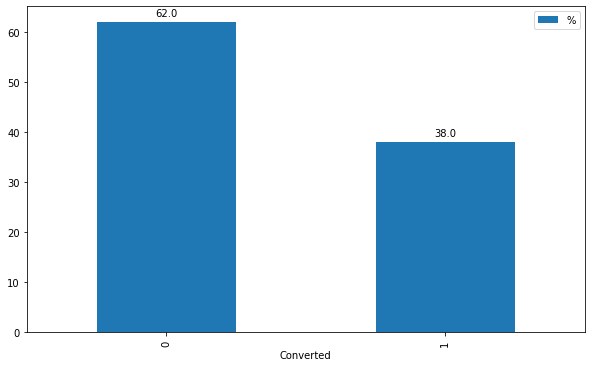

In [6977]:
# How is the distribution wrt the target variable?
df_converted = df[COLS_TARGET].groupby(by='Converted').agg({'Converted':'count'}).rename(columns={'Converted':'Count'})
df_converted.reset_index(inplace=True)
df_converted['%'] = df_converted['Count'].apply(lambda x: round(100 * x/df.shape[0]))
ax = df_converted.plot.bar(x='Converted', y='%', figsize=(10,6))
utils.annotate(ax)
df_converted

- Target variable is a binary value - 0 or 1
- The data is not imbalanced.

### Summary
| Category | Column Name | Missing values? | Handling |
|---|---|---|---|
| LOC | Country | 26% | For 2461 rows Country is null and only very few countries are outside india, precisely only 287 i.e. only 3% of data. If we impute India as missing values, then majority data would only be India and thiss column would add no significance to analysis. So let us DROP Country. |
| LOC | City |  |Many countries (Australia, Bahrain etc.) have City as "'Thane & Outskirts', 'Other Cities of Maharashtra', 'Mumbai' which is incorrect. So we should DROP City. | 
|PROF| Occupation | 29% | Group NaN and non Unemployed categories as Others |
|PROF| Reason | 29% | Around 29% rows have null Reason. We can impute the Reason with 'Better Career Prospects'. But then only .03% rows have Reason other than 'Better Career Prospects'. So the column Reason will add no significance to the model. So DROP the column Reason |
|PROF| Specialization | 15.6% | Replace NaN with 'Others' |
|AD| Found | 70% | Remove column |
| AD| AdXXX | - | - | Remove Column as almost all rows have the same value 'No' |
|AD| Recommendations | - | - | Remove Column as almost all rows have the same value 'No' |
|PREF| XXX |  - | Remove as almost all rows have the same value 'No' |
|PREF| NoEmail |  - | - |
|PREF| FreeCopy |  - | - |
|ACTIVITY| TotalVisits | 1.5% | - | Remove the rows with null values |
|ACTIVITY| PageViews | 1.5% | - | Remove the rows with null values |
|ACTIVITY| TimeSpent | -  | - | - |
|ACTIVITY| LastActivity |  1.1% | -  | Remove the rows with null values |
|ACTIVITY| LastNotableActivity | - | - | - |
|LEAD| LeadNumber | - | - |
|LEAD| LeadOrigin | - | - |
|LEAD| LeadSource | 0.4% | Remove the rows with null values |
|LEAD| LeadQuality | 51.6% | |
|LEAD| LeadProfile | 29.3% | |
|LEAD| Tags | 36.3% | |
|INDEXSCORE| ActivityIndex | 45.6%  | Almost half of the values are missing. Remove the column |
|INDEXSCORE| ProfileIndex | 45.6%  | Almost half of the values are missing. Remove the column |
|INDEXSCORE| ActivityScore | 45.6%  | Almost half of the values are missing. Remove the column |
|INDEXSCORE| ProfileScore | 45.6%  | Almost half of the values are missing. Remove the column |

### How are customers who are converted to paid customers?
What are the characteristics of the customers who are converted and not converted?

## Bivariate Analysis

<AxesSubplot:>

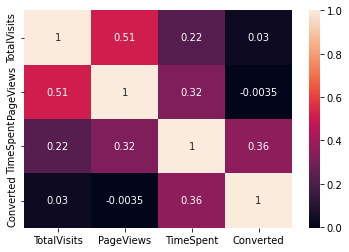

In [6978]:
sns.heatmap(df.corr(),annot=True)

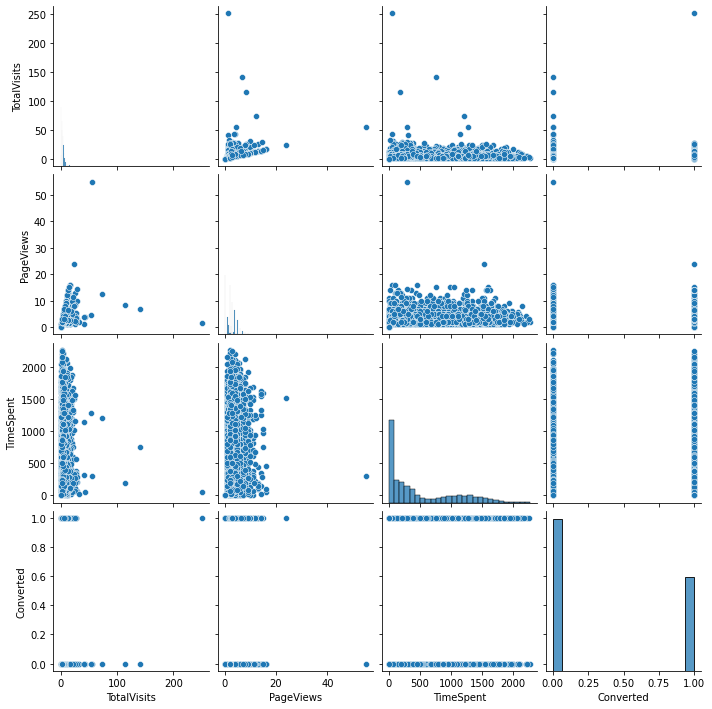

In [6979]:
sns.pairplot(data=df)

There is small correlation between TotalVisits and TimeSpent

## Model

In [6980]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9137 entries, 0 to 9239
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         9137 non-null   object 
 1   Occupation      9137 non-null   object 
 2   Specialization  9137 non-null   object 
 3   Found           9137 non-null   object 
 4   NoEmail         9137 non-null   object 
 5   FreeCopy        9137 non-null   object 
 6   TotalVisits     9137 non-null   float64
 7   PageViews       9137 non-null   float64
 8   TimeSpent       9137 non-null   int64  
 9   LastActivity    9137 non-null   object 
 10  LeadOrigin      9137 non-null   object 
 11  LeadSource      9137 non-null   object 
 12  LeadQuality     4395 non-null   object 
 13  Converted       9137 non-null   int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 1.3+ MB


In [6981]:
print(df.shape, df.columns.tolist())

(9137, 14) ['Country', 'Occupation', 'Specialization', 'Found', 'NoEmail', 'FreeCopy', 'TotalVisits', 'PageViews', 'TimeSpent', 'LastActivity', 'LeadOrigin', 'LeadSource', 'LeadQuality', 'Converted']


In [6982]:
COLS_YESNO =  ['FreeCopy', 'NoEmail']
COLS_DUMMIES = ['Country', 'Occupation', 'Specialization', 'Found', 'LastActivity', 'LeadOrigin', 'LeadSource', 'LeadQuality', 'Tags']
COLS_NUMERIC = ['TotalVisits', 'PageViews', 'TimeSpent']

df_numeric = df[COLS_NUMERIC]
df_numeric

,TotalVisits,PageViews,TimeSpent
0,0.0,0.00,0
1,5.0,2.50,674
2,2.0,2.00,1532
3,1.0,1.00,305
4,2.0,1.00,1428
...,...,...,...
9235,8.0,2.67,1845
9236,2.0,2.00,238
9237,2.0,2.00,199
9238,3.0,3.00,499


#### Converting some binary variables (Yes/No) to 0/1

In [6983]:
df[COLS_YESNO]

,FreeCopy,NoEmail
0,No,No
1,No,No
2,Yes,No
3,No,No
4,No,No
...,...,...
9235,No,Yes
9236,Yes,No
9237,Yes,Yes
9238,No,No


In [6984]:
# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
print("Before\n", df[COLS_YESNO].head())
df_yesno = df[COLS_YESNO].apply(binary_map)
print("After\n", df_yesno.head())

Before
   FreeCopy NoEmail
0       No      No
1       No      No
2      Yes      No
3       No      No
4       No      No
After
    FreeCopy  NoEmail
0         0        0
1         0        0
2         1        0
3         0        0
4         0        0


#### For categorical variables with multiple levels, create dummy features (one-hot encoded)

In [6985]:
def addDummies(df, col, dropcat, df_out):
    print("Before", df_out.columns.shape[0], end=' ')
    temp = pd.get_dummies(df[col], prefix=col)
    #df.drop(columns=[col], inplace=True)
    temp = temp.drop([dropcat], 1)
    #Adding the results to the master dataframe
    df_out = pd.concat([df_out, temp], axis=1)
    print("After", df_out.columns.shape[0])
    return df_out

In [6986]:
df['LeadQuality'].value_counts()

Might be             1539
Not Sure             1087
High in Relevance     611
Worst                 601
Low in Relevance      557
Name: LeadQuality, dtype: int64

In [6987]:
COLS_DUMMIES = ['Country', 'Occupation', 'Specialization', 'Found', 'LastActivity', 'LeadOrigin', 'LeadSource', 'LeadQuality', 'Tags']

df_dummies = pd.DataFrame()
df_dummies = addDummies(df, 'Country', 'Country_UNKNOWN', df_dummies)
df_dummies = addDummies(df, 'Occupation', 'Occupation_UNKNOWN', df_dummies)
df_dummies = addDummies(df, 'Specialization', 'Specialization_UNKNOWN', df_dummies)
df_dummies = addDummies(df, 'Found', 'Found_UNKNOWN', df_dummies)
df_dummies = addDummies(df, 'LastActivity','LastActivity_Resubscribed to emails', df_dummies)
#df_dummies = addDummies(df, 'LastActivity', 'LastActivity_OTHERS', df_dummies)
df_dummies = addDummies(df, 'LeadOrigin', 'LeadOrigin_Quick Add Form', df_dummies)
df_dummies = addDummies(df, 'LeadSource', 'LeadSource_NC_EDM', df_dummies)
#df_dummies = addDummies(df, 'LeadSource', 'LeadSource_OTHERS', df_dummies)
df_dummies = addDummies(df, 'LeadQuality', 'LeadQuality_Low in Relevance', df_dummies)
#df_dummies = addDummies(df, 'Tags', 'Tags_UNKNOWN', df_dummies)

Before 0 After 2
Before 2 After 8
Before 8 After 26
Before 26 After 28
Before 28 After 44
Before 44 After 48
Before 48 After 68
Before 68 After 72


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [6988]:
print(df_dummies.info())
print(df_dummies.head())
df_target = df[COLS_TARGET]
print(df_target)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9137 entries, 0 to 9239
Data columns (total 72 columns):
 #   Column                                            Non-Null Count  Dtype
---  ------                                            --------------  -----
 0   Country_India                                     9137 non-null   uint8
 1   Country_OTHERS                                    9137 non-null   uint8
 2   Occupation_Businessman                            9137 non-null   uint8
 3   Occupation_Housewife                              9137 non-null   uint8
 4   Occupation_Other                                  9137 non-null   uint8
 5   Occupation_Student                                9137 non-null   uint8
 6   Occupation_Unemployed                             9137 non-null   uint8
 7   Occupation_Working Professional                   9137 non-null   uint8
 8   Specialization_Banking, Investment And Insurance  9137 non-null   uint8
 9   Specialization_Business Administration   

In [6989]:
# Adding the results to the master dataframe
df = pd.concat([df_numeric, df_yesno, df_dummies], axis=1)
print(df.head())
print(df.info())
print(df.shape, df.isnull().sum().sum())

   TotalVisits  PageViews  TimeSpent  FreeCopy  NoEmail  Country_India  \
0          0.0        0.0          0         0        0              0   
1          5.0        2.5        674         0        0              1   
2          2.0        2.0       1532         1        0              1   
3          1.0        1.0        305         0        0              1   
4          2.0        1.0       1428         0        0              1   

   Country_OTHERS  Occupation_Businessman  Occupation_Housewife  \
0               0                       0                     0   
1               0                       0                     0   
2               0                       0                     0   
3               0                       0                     0   
4               0                       0                     0   

   Occupation_Other  ...  LeadSource_Welingak Website  LeadSource_bing  \
0                 0  ...                            0                0   
1   

## Model Building

In [6990]:
print(df.columns.tolist())

['TotalVisits', 'PageViews', 'TimeSpent', 'FreeCopy', 'NoEmail', 'Country_India', 'Country_OTHERS', 'Occupation_Businessman', 'Occupation_Housewife', 'Occupation_Other', 'Occupation_Student', 'Occupation_Unemployed', 'Occupation_Working Professional', 'Specialization_Banking, Investment And Insurance', 'Specialization_Business Administration', 'Specialization_E-Business', 'Specialization_E-COMMERCE', 'Specialization_Finance Management', 'Specialization_Healthcare Management', 'Specialization_Hospitality Management', 'Specialization_Human Resource Management', 'Specialization_IT Projects Management', 'Specialization_International Business', 'Specialization_Marketing Management', 'Specialization_Media and Advertising', 'Specialization_Operations Management', 'Specialization_Retail Management', 'Specialization_Rural and Agribusiness', 'Specialization_Services Excellence', 'Specialization_Supply Chain Management', 'Specialization_Travel and Tourism', 'Found_OTHERS', 'Found_Online Search', 

In [6991]:
X = df

In [6992]:
y = df_target['Converted']

In [6993]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)
print(X_train.shape[0], X_test.shape[0])

6395 2742


In [6994]:
scaler = StandardScaler()
X_train[COLS_NUMERIC] = scaler.fit_transform(X_train[COLS_NUMERIC])
X_train.head()

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,TotalVisits,PageViews,TimeSpent,FreeCopy,NoEmail,Country_India,Country_OTHERS,Occupation_Businessman,Occupation_Housewife,Occupation_Other,...,LeadSource_Welingak Website,LeadSource_bing,LeadSource_blog,LeadSource_testone,LeadSource_welearnblog_Home,LeadSource_youtubechannel,LeadQuality_High in Relevance,LeadQuality_Might be,LeadQuality_Not Sure,LeadQuality_Worst
8701,-0.607948,-0.623541,0.211070,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6684,0.392522,1.198971,1.815810,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4406,-0.858065,-1.079169,-0.883322,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2487,-0.858065,-1.079169,-0.883322,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
561,-0.107713,0.287715,2.140074,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [6995]:
'''plt.figure(figsize = (20,10))
sns.heatmap(X_train.corr(),annot = True)
plt.show()'''

'plt.figure(figsize = (20,10))\nsns.heatmap(X_train.corr(),annot = True)\nplt.show()'

### Build model

In [6996]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: divide by zero encountered in log
  y * np.log(mu / (1 - mu + 1e-20)) +
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: invalid value encountered in multiply
  y * np.log(mu / (1 - mu + 1e-20)) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6395
Model:                            GLM   Df Residuals:                     6321
Model Family:                Binomial   Df Model:                           73
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 10 Oct 2021   Deviance:                   1.1145e+05
Time:                        11:53:17   Pearson chi2:                 5.45e+18
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                             9.325e+15   7.88e+07   1.18e+08      0.000    9.33e+15    9.33e+15
TotalVisits                                       2.733e+13   1.15e+06   2.37e+07      0.000    2.73e+13    2.73e+13
PageViews                                        -5.719e+13   1.27e+06  -4.49e+07      0.000   -5.72e+13   -5.72e+13
TimeSpent                                         1.809e+14   9.94e+05   1.82e+08      0.000    1.81e+14    1.81e+14
FreeCopy                                          6.432e+13   3.26e+06   1.97e+07      0.000    6.43e+13    6.43e+13
NoEmail                                          -6.118e+14   4.45e+06  -1.37e+08      0.000   -6.12e+14   -6.12e+14
Country_India                                    -1.253e+14   6.47e+06  -1.94e+07      0.000   -1.25e+14   -1.25e+14
Country_OTHERS                                   -6.084e+13   7.88e+06  -7.73e+06      0.000   -6.08e+13   -6.08e+13
Occupation_Businessman                           -5.322e+14   2.76e+07  -1.93e+07      0.000   -5.32e+14   -5.32e+14
Occupation_Housewife                              2.543e+15   2.56e+07   9.93e+07      0.000    2.54e+15    2.54e+15
Occupation_Other                                  1.161e+15   1.82e+07   6.38e+07      0.000    1.16e+15    1.16e+15
Occupation_Student                                 8.93e+14   6.24e+06   1.43e+08      0.000    8.93e+14    8.93e+14
Occupation_Unemployed                             3.634e+14   2.29e+06   1.59e+08      0.000    3.63e+14    3.63e+14
Occupation_Working Professional                   1.231e+15   4.18e+06   2.94e+08      0.000    1.23e+15    1.23e+15
Specialization_Banking, Investment And Insurance  5.142e+14   5.31e+06   9.67e+07      0.000    5.14e+14    5.14e+14
Specialization_Business Administration            6.692e+14   5.02e+06   1.33e+08      0.000    6.69e+14    6.69e+14
Specialization_E-Business                         3.979e+14   1.21e+07   3.28e+07      0.000    3.98e+14    3.98e+14
Specialization_E-COMMERCE                         4.478e+14   7.84e+06   5.71e+07      0.000    4.48e+14    4.48e+14
Specialization_Finance Management                 7.122e+14      4e+06   1.78e+08      0.000    7.12e+14    7.12e+14
Specialization_Healthcare Management              7.376e+14   7.15e+06   1.03e+08      0.000    7.38e+14    7.38e+14
Specialization_Hospitality Management             1.502e+14    8.2e+06   1.83e+07      0.000     1.5e+14     1.5e+14
Specialization_Human Resource Management          6.114e+14   3.76e+06   1.63e+08      0.000    6.11e+14    6.11e+14
Specialization_IT Projects Management             5.872e+14   5.21e+06   1.13e+08      0.000    5.87e+14    5.87e+14
Specialization_International Business    

In [6997]:
cols = runRFE(15, X_train, y_train )

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765

Columns selected by RFE: ['NoEmail', 'Occupation_Housewife', 'Occupation_Other', 'Occupation_Student', 'Occupation_Unemployed', 'Occupation_Working Professional', 'LastActivity_Olark Chat Conversation', 'LastActivity_SMS Sent', 'LastActivity_Unsubscribed', 'LeadOrigin_Lead Add Form', 'LeadOrigin_Lead Import', 'LeadSource_Welingak Website', 'LeadQuality_High in Relevance', 'LeadQuality_Not Sure', 'LeadQuality_Worst']
Columns dropped by RFE: ['LeadSource_testone', 'TimeSpent', 'LeadSource_Olark Chat', 'LeadSource_Live Chat', 'Country_OTHERS', 'LeadSource_Google', 'Specialization_Human Resource Management', 'LeadSource_Referral Sites', 'Specialization_Finance Management', 'TotalVisits', 'LeadSource_Pay per Click Ads', 'LeadSource_Facebook', 'Specialization_Operations Management', 'LastActivity_Email Link Clicked', 'LeadSource_youtubechannel', 'Found_Online Search', 'LeadSource_Press_Release', 'LeadSource_Reference', 'LeadSource_bing', 'Specialization_Healthcare Management', 'Specializatio

In [6998]:
X_train = X_train[cols]
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6395
Model:                            GLM   Df Residuals:                     6379
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2689.5
Date:                Sun, 10 Oct 2021   Deviance:                       5378.9
Time:                        11:53:20   Pearson chi2:                 6.40e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [6999]:
# Grouping
# lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, col='Country_OTHERS')

In [7000]:
# No Grouping, drop Tags
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, col='Occupation_Housewife')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6395
Model:                            GLM   Df Residuals:                     6380
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2702.2
Date:                Sun, 10 Oct 2021   Deviance:                       5404.4
Time:                        11:53:20   Pearson chi2:                 6.43e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [7001]:
# No Grouping, drop Tags
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, col='LeadSource_Welingak Website')

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6395
Model:                            GLM   Df Residuals:                     6381
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2713.8
Date:                Sun, 10 Oct 2021   Deviance:                       5427.5
Time:                        11:53:20   Pearson chi2:                 6.77e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


                                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -2.0318      0.078    -26.200      0.000      -2.184      -1.880
NoEmail                                 -1.5003      0.175     -8.594      0.000      -1.842      -1.158
Occupation_Other                         3.4477      0.769      4.481      0.000       1.940       4.956
Occupation_Student                       2.4818      0.275      9.041      0.000       1.944       3.020
Occupation_Unemployed                    1.4739      0.083     17.659      0.000       1.310       1.638
Occupation_Working Professional          3.8724      0.195     19.814      0.000       3.489       4.255
LastActivity_Olark Chat Conversation    -0.9193      0.150     -6.113      0.000      -1.214      -0.625
LastActivity_SMS Sent                    1.4507      0.074     19.577      0.000       1.305       1.596
LastActivity_Unsubscribed                1.3751      0.460      2.991      0.003       0.474       2.276
LeadOrigin_Lead Add Form                 2.0575      0.206      9.996      0.000       1.654       2.461
LeadOrigin_Lead Import                  -1.0358      0.502     -2.062      0.039      -2.020      -0.051
LeadQuality_High in Relevance            2.8610      0.226     12.676      0.000       2.419       3.303
LeadQuality_Not Sure                    -1.3883      0.106    -13.077      0.000      -1.596      -1.180
LeadQuality_Worst                       -3.7939      0.398     -9.537      0.000      -4.574      -3.014

In [7002]:
# No Grouping
'''lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, col='Tags_number not provided')
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, col='Tags_Diploma holder (Not Eligible)')
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, col='LeadSource_Welingak Website')
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, col='Tags_wrong number given')'''

"lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, col='Tags_number not provided')\nlr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, col='Tags_Diploma holder (Not Eligible)')\nlr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, col='LeadSource_Welingak Website')\nlr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, col='Tags_wrong number given')"

In [7003]:
print(X_train.columns.shape[0], X_train.columns)

13 Index(['NoEmail', 'Occupation_Other', 'Occupation_Student',
       'Occupation_Unemployed', 'Occupation_Working Professional',
       'LastActivity_Olark Chat Conversation', 'LastActivity_SMS Sent',
       'LastActivity_Unsubscribed', 'LeadOrigin_Lead Add Form',
       'LeadOrigin_Lead Import', 'LeadQuality_High in Relevance',
       'LeadQuality_Not Sure', 'LeadQuality_Worst'],
      dtype='object')


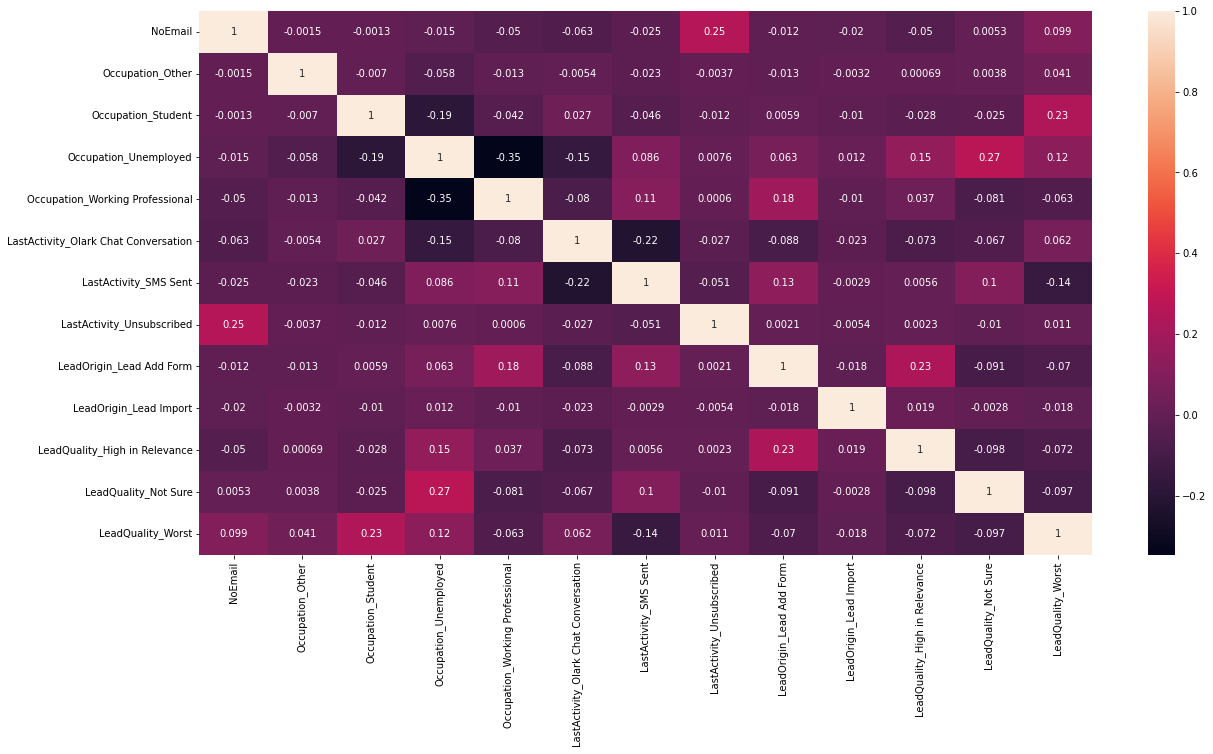

In [7004]:
plt.figure(figsize = (20,10))
sns.heatmap(X_train.corr(),annot = True)
plt.show()

### Predict Train 

In [7005]:
y_train_pred_final = predict(lr_model, X_train_sm, y_train)

   Lead_Actual  Lead_Prob  Lead_ID  Lead_Predicted
0            1   0.115901     8701               0
1            0   0.378588     6684               0
2            1   0.950276     4406               1
3            1   0.709464     2487               1
4            0   0.378588      561               0


In [7006]:
confusionmatrix(y_train_pred_final, 'Lead_Actual', 'Lead_Predicted')

[[3670  294]
 [ 960 1471]]
Accuracy: 80.39% Sensitivity: 60.51% Specificity: 92.58% FPR: 7.42% PPV: 83.34%


<Figure size 360x360 with 0 Axes>

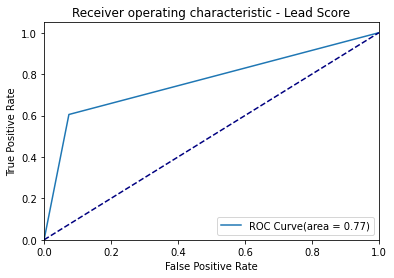

In [7007]:
fpr,tpr,thresholds = metrics.roc_curve(y_train_pred_final['Lead_Actual'],y_train_pred_final['Lead_Predicted'])
draw_roc(y_train_pred_final['Lead_Actual'],y_train_pred_final['Lead_Predicted'])

In [7008]:
## Optimal cut off point
## Problem statement is to obtain lead conversion rate as 80%
numbers = [float(x)/10 for x in range (10)]
for i in numbers:
    y_train_pred_final[i] = y_train_pred_final['Lead_Prob'].map(lambda x: 1 if x>i else 0)
y_train_pred_final

,Lead_Actual,Lead_Prob,Lead_ID,Lead_Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.115901,8701,0,1,1,0,0,0,0,0,0,0,0
1,0,0.378588,6684,0,1,1,1,1,0,0,0,0,0,0
2,1,0.950276,4406,1,1,1,1,1,1,1,1,1,1,1
3,1,0.709464,2487,1,1,1,1,1,1,1,1,1,0,0
4,0,0.378588,561,0,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6390,0,0.115901,366,0,1,1,0,0,0,0,0,0,0,0
6391,1,0.863012,82,1,1,1,1,1,1,1,1,1,1,0
6392,0,0.364035,8139,0,1,1,1,1,0,0,0,0,0,0
6393,0,0.034093,7028,0,1,0,0,0,0,0,0,0,0,0


In [7009]:
# Calculate accuracy, sensitivity & specificity for probab cut offs
cutoff_df = pd.DataFrame(columns=['prob','accuracy','sensi','speci'])

for i in numbers:
    cm1 = metrics.confusion_matrix(y_train_pred_final['Lead_Actual'],y_train_pred_final[i])
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] = [i,accuracy,sensi,speci]
print (cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.380141  1.000000  0.000000
0.1   0.1  0.532760  0.991362  0.251514
0.2   0.2  0.723534  0.902098  0.614026
0.3   0.3  0.725410  0.902098  0.617053
0.4   0.4  0.804066  0.607158  0.924823
0.5   0.5  0.803909  0.605101  0.925832
0.6   0.6  0.804378  0.604278  0.927094
0.7   0.7  0.802502  0.593172  0.930878
0.8   0.8  0.764191  0.406417  0.983602
0.9   0.9  0.727912  0.299054  0.990918


<Figure size 720x720 with 0 Axes>

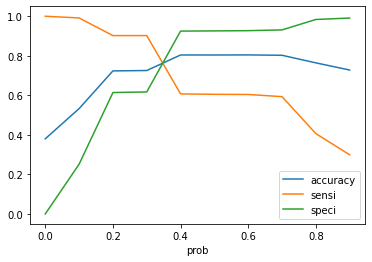

In [7010]:
# plot accuracy, sensitivity & specificity
plt.figure(figsize=(10,10))
cutoff_df.plot.line(x='prob',y=['accuracy','sensi','speci'])
plt.show()

In [7011]:
OPTIMUM_CUTOFF = 0.35

In [7012]:
## New prdicted variable column
y_train_pred_final['Lead_Predicted_opt'] = y_train_pred_final['Lead_Prob'].map(lambda x:1 if x> OPTIMUM_CUTOFF else 0)
y_train_pred_final

,Lead_Actual,Lead_Prob,Lead_ID,Lead_Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Lead_Predicted_opt
0,1,0.115901,8701,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.378588,6684,0,1,1,1,1,0,0,0,0,0,0,1
2,1,0.950276,4406,1,1,1,1,1,1,1,1,1,1,1,1
3,1,0.709464,2487,1,1,1,1,1,1,1,1,1,0,0,1
4,0,0.378588,561,0,1,1,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6390,0,0.115901,366,0,1,1,0,0,0,0,0,0,0,0,0
6391,1,0.863012,82,1,1,1,1,1,1,1,1,1,1,0,1
6392,0,0.364035,8139,0,1,1,1,1,0,0,0,0,0,0,1
6393,0,0.034093,7028,0,1,0,0,0,0,0,0,0,0,0,0


In [7013]:
confusionmatrix(y_train_pred_final, 'Lead_Actual', 'Lead_Predicted_opt')

[[2456 1508]
 [ 243 2188]]
Accuracy: 72.62% Sensitivity: 90.0% Specificity: 61.96% FPR: 38.04% PPV: 59.2%


### Predict Test 

In [7014]:
X_test.columns.tolist()

['TotalVisits',
 'PageViews',
 'TimeSpent',
 'FreeCopy',
 'NoEmail',
 'Country_India',
 'Country_OTHERS',
 'Occupation_Businessman',
 'Occupation_Housewife',
 'Occupation_Other',
 'Occupation_Student',
 'Occupation_Unemployed',
 'Occupation_Working Professional',
 'Specialization_Banking, Investment And Insurance',
 'Specialization_Business Administration',
 'Specialization_E-Business',
 'Specialization_E-COMMERCE',
 'Specialization_Finance Management',
 'Specialization_Healthcare Management',
 'Specialization_Hospitality Management',
 'Specialization_Human Resource Management',
 'Specialization_IT Projects Management',
 'Specialization_International Business',
 'Specialization_Marketing Management',
 'Specialization_Media and Advertising',
 'Specialization_Operations Management',
 'Specialization_Retail Management',
 'Specialization_Rural and Agribusiness',
 'Specialization_Services Excellence',
 'Specialization_Supply Chain Management',
 'Specialization_Travel and Tourism',
 'Found_O

In [7015]:
## Scaling the data
X_test[COLS_NUMERIC] = scaler.transform(X_test[COLS_NUMERIC])
X_test.head()

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,TotalVisits,PageViews,TimeSpent,FreeCopy,NoEmail,Country_India,Country_OTHERS,Occupation_Businessman,Occupation_Housewife,Occupation_Other,...,LeadSource_Welingak Website,LeadSource_bing,LeadSource_blog,LeadSource_testone,LeadSource_welearnblog_Home,LeadSource_youtubechannel,LeadQuality_High in Relevance,LeadQuality_Might be,LeadQuality_Not Sure,LeadQuality_Worst
5080,-0.107713,0.287715,1.603933,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1893,1.142874,-0.167913,-0.594064,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5432,-0.858065,-1.079169,-0.883322,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3549,0.142405,0.743343,1.336783,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8231,0.392522,1.198971,-0.826208,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7016]:
print(len(cols), cols, dropped_cols)
cols = list(set(cols) - set(dropped_cols))
print(len(cols), cols)

15 ['NoEmail', 'Occupation_Housewife', 'Occupation_Other', 'Occupation_Student', 'Occupation_Unemployed', 'Occupation_Working Professional', 'LastActivity_Olark Chat Conversation', 'LastActivity_SMS Sent', 'LastActivity_Unsubscribed', 'LeadOrigin_Lead Add Form', 'LeadOrigin_Lead Import', 'LeadSource_Welingak Website', 'LeadQuality_High in Relevance', 'LeadQuality_Not Sure', 'LeadQuality_Worst'] ['LeadSource_testone', 'TimeSpent', 'LeadSource_Olark Chat', 'LeadSource_Live Chat', 'Country_OTHERS', 'LeadSource_Google', 'Specialization_Human Resource Management', 'LeadSource_Referral Sites', 'Specialization_Finance Management', 'TotalVisits', 'LeadSource_Pay per Click Ads', 'LeadSource_Facebook', 'Specialization_Operations Management', 'LastActivity_Email Link Clicked', 'LeadSource_youtubechannel', 'Found_Online Search', 'LeadSource_Press_Release', 'LeadSource_Reference', 'LeadSource_bing', 'Specialization_Healthcare Management', 'Specialization_Retail Management', 'LeadQuality_Might be', 

In [7017]:
X_test = X_test[cols]
X_test.head()

,LastActivity_Unsubscribed,LeadQuality_Worst,Occupation_Working Professional,LastActivity_Olark Chat Conversation,Occupation_Unemployed,LeadOrigin_Lead Import,LeadQuality_High in Relevance,LeadOrigin_Lead Add Form,LastActivity_SMS Sent,Occupation_Other,Occupation_Student,NoEmail,LeadQuality_Not Sure
5080,0,0,0,0,1,0,0,0,0,0,0,0,0
1893,0,0,0,0,0,0,0,0,0,0,0,0,0
5432,0,0,0,0,0,0,0,0,1,0,0,1,0
3549,0,0,1,0,0,0,0,0,1,0,0,0,0
8231,0,0,0,0,1,0,0,0,1,0,0,0,0


In [7018]:
X_test_sm = sm.add_constant(X_test)

/Users/sreedevigattu/sree/PGDS/MachineLearning/venv/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [7019]:
print(len(X_test_sm.columns.tolist()), X_test_sm.columns.tolist())

14 ['const', 'LastActivity_Unsubscribed', 'LeadQuality_Worst', 'Occupation_Working Professional', 'LastActivity_Olark Chat Conversation', 'Occupation_Unemployed', 'LeadOrigin_Lead Import', 'LeadQuality_High in Relevance', 'LeadOrigin_Lead Add Form', 'LastActivity_SMS Sent', 'Occupation_Other', 'Occupation_Student', 'NoEmail', 'LeadQuality_Not Sure']


In [7020]:
y_test_pred_final =  predict(lr_model, X_test_sm, y_test)

   Lead_Actual  Lead_Prob  Lead_ID  Lead_Predicted
0            1   0.863012     5080               1
1            0   0.115901     1893               0
2            1   0.203807     5432               0
3            1   0.924661     3549               1
4            0   0.980121     8231               1


In [7021]:
## New prdicted variable column
y_test_pred_final['Lead_Predicted_opt'] = y_test_pred_final['Lead_Prob'].map(lambda x:1 if x > OPTIMUM_CUTOFF else 0)
y_test_pred_final

,Lead_Actual,Lead_Prob,Lead_ID,Lead_Predicted,Lead_Predicted_opt
0,1,0.863012,5080,1,1
1,0,0.115901,1893,0,0
2,1,0.203807,5432,0,0
3,1,0.924661,3549,1,1
4,0,0.980121,8231,1,1
...,...,...,...,...,...
2737,0,0.382390,579,0,1
2738,0,0.863012,968,1,1
2739,1,0.980121,4477,1,1
2740,1,0.863012,4528,1,1


In [7022]:
confusionmatrix(y_test_pred_final, 'Lead_Actual', 'Lead_Predicted_opt')

[[ 624 1069]
 [  85  964]]
Accuracy: 57.91% Sensitivity: 91.9% Specificity: 36.86% FPR: 63.14% PPV: 47.42%


### Interpretation of the model
|	variable	|	co-efficient	|	Interpretation	|
|	---	|	---	|	---	|
|	Occupation_Working Professional 	|	3.8724	|	Working Professionals are more likely to convert to paid users	|
|	Occupation_Other	|	3.4477	|	Customers with occupation Other are more likely to convert to paid users	|
|	LeadQuality_High in Relevance 	|	2.861	|	Leads marked with High Relevance are more likely to convert to paid users	|
|	Occupation_Student	|	2.4818	|	Students are likely to convert to paid users	|
|	LeadOrigin_Lead Add Form 	|	2.0575	|	Leads from filling a form are likely to convert to paid users	|
|	Occupation_Unemployed	|	1.4739	|	Unemployed customers are likely to convert to paid users	|
|	LastActivity_SMS Sent	|	1.4507	|	Unemployed customers are likely to convert to paid users	|
|	LastActivity_Unsubscribed	|	1.3751	|	Unemployed customers are likely to convert to paid users	|
|	LastActivity_Olark Chat Conversation	|	-0.9193	|	-	|
|	LeadOrigin_Lead Import 	|	-1.0358	|	-	|
|	LeadQuality_Not Sure 	|	-1.3883	|	Leads marked as Not sure are less likely to convert to paid users	|
|	NoEmail	|	-1.5003	|	"Customers who have marked Do Not Email as Yes are less likely to convert to paid users OR
Customers who have marked Do Not Email as No are more likely to convert to paid users"	|
|	const	|	-2.0318	|	-	|
|	LeadQuality_Worst	|	-3.7939	|	Leads marked as Worst quality are least likely to convert to paid users	|